

#### **Projeto de Data Science**
*by [Artur Freitas](https://www.linkedin.com/in/artur-sn-freitas/)*

---

# Análise dos dados de alugueis temporários - *Nova York*

Você foi alocado(a) em um time da Indicium que está trabalhando atualmente junto a um cliente no processo de criação de uma plataforma de aluguéis temporários na cidade de Nova York. Para o desenvolvimento de sua estratégia de precificação, pediu para que a Indicium fizesse uma análise exploratória dos dados de seu maior concorrente, assim como um teste de validação de um modelo preditivo.

Seu objetivo é desenvolver um modelo de previsão de preços a partir do dataset oferecido, e avaliar tal modelo utilizando as métricas de avaliação que mais fazem sentido para o problema.



## Dados fornecidos


In [169]:
# importando os pacotes necessarios para a análise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn.metrics import r2_score

In [2]:
# importar o arquivo listings.csv para um DataFrame
df = pd.read_csv("teste_indicium_precificacao.csv")
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


## Análise Exploratória dos Dados

Esta etapa tem por objetivo criar uma consciência situacional inicial e permitir um entendimento de como os dados estão estruturados.

**Dicionário das variáveis**

* `id` - número de id gerado para identificar o imóvel
* `name` - nome da propriedade anunciada
* `host_id` - número de id do proprietário (anfitrião) da propriedade
* `host_name` - Nome do anfitrião
* `bairro_group` - distritos compostos por outros bairros
* `bairro` - nome do bairro
* `latitude` - coordenada da latitude da propriedade
* `longitude` - coordenada da longitude da propriedade
* `room_type` - informa o tipo de quarto que é oferecido
* `price` - preço para alugar o imóvel
* `minimo_noites` - quantidade mínima de noites para reservar
* `numero_de_reviews` - número de reviews que a propriedade possui
* `ultima_review` - data do último review
* `reviews_por_mes` - quantidade de reviews por mês
* `calculado_host_listings_count` - quantidade de imóveis do mesmo anfitrião
* `disponibilidade_365` - número de dias de disponibilidade dentro de 365 dias

### **- Quantos atributos (variáveis) e quantas entradas o nosso conjunto de dados possui? Quais os tipos das variáveis?**

Vamos prosseguir e identificar a quantidade de entradas que nosso conjunto de dados possui e ver os tipos de cada coluna.


In [3]:
# número de linhas:
print('Entradas: ', df.shape[0])

# número de colunas:
print('Variáveis: ', df.shape[1])

# verificar as 5 primeiras entradas do dataset
df.info()

Entradas:  48894
Variáveis:  16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review 

Este *dataset* fornecido tem 16 variáveis e 48894 linhas. Já vemos que a ultima_review não está como data

### **- Qual a porcentagem de valores ausentes no *dataset*?**

A qualidade de um *dataset* está diretamente relacionada à quantidade de valores ausentes. É importante entender logo no início se esses valores nulos são significativos comparados ao total de entradas.


In [4]:
# ordenar em ordem decrescente as variáveis por seus valores ausentes
(df.isnull().sum() / df.shape[0]).sort_values(ascending = False)

ultima_review                    0.205588
reviews_por_mes                  0.205588
host_name                        0.000430
nome                             0.000327
id                               0.000000
host_id                          0.000000
bairro_group                     0.000000
bairro                           0.000000
latitude                         0.000000
longitude                        0.000000
room_type                        0.000000
price                            0.000000
minimo_noites                    0.000000
numero_de_reviews                0.000000
calculado_host_listings_count    0.000000
disponibilidade_365              0.000000
dtype: float64

* As variáveis `reviews_per_month` e `last_review` possuem valores nulos em aproximadamente 26% das entradas. Provavelmente alguns dos imóveis nunca tiveram nenhuma *review*.
* As variáveis `name` e `host_name` possuem alguns poucos valores nulos.

### **-  Qual o tipo de distribuição das variáveis? Existem outliers?** 

Através dessas funções podemos analisar essas questões em cada variável numérica e categórica

In [5]:
def numerical_plot(df, target='price'):   
    cols = 3
    num_cols = df.select_dtypes(include='number').iloc[:, 1:-1].columns
    rows = len(num_cols)

    figure, axs = plt.subplots(rows,cols,figsize = (20,rows*5))

    for i, col in enumerate(num_cols):
        sns.histplot(df[col], fill = True, kde= True, ax=axs[i,0])
        sns.boxplot(df[col], ax=axs[i,1])
        sns.scatterplot(x=df[col], y=df[target], ax=axs[i,2])
        axs[i,0].set_title(f"Dist. of {col}; Skew:{round(df[col].skew(),2)}; Null:{round(100*(df[col].isnull().sum()/len(df)),2)}%")
        axs[i,1].set_title(f"Boxplot of {col}")
        axs[i,2].set_title(f"Scatterplot : {target} v. {col}")
    plt.tight_layout()
    plt.show()
    
def category_plot(df, target='price'): 
    cat_cols = df.select_dtypes(include=['object','category','bool']).columns

    # Create subplots with appropriate rows and columns
    n_cols = 2
    n_rows = len(cat_cols) # Adjust for desired layout
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
    # Iterate through columns and plot barplots
    for i, col in enumerate(cat_cols):
        sns.barplot(x=df[col].value_counts().values, y=df[col].value_counts().index, ax=axs[i,0])
        sns.boxplot(x=col, y=target, data=df, ax=axs[i,1])
        axs[i,0].set_title(f"Distribution of {col}. Null:{round(100*(df[col].isnull().sum()/len(df)),2)}%")
        axs[i,1].set_title(f"Boxplot of {col}.")
        
    plt.tight_layout() 
    plt.show()

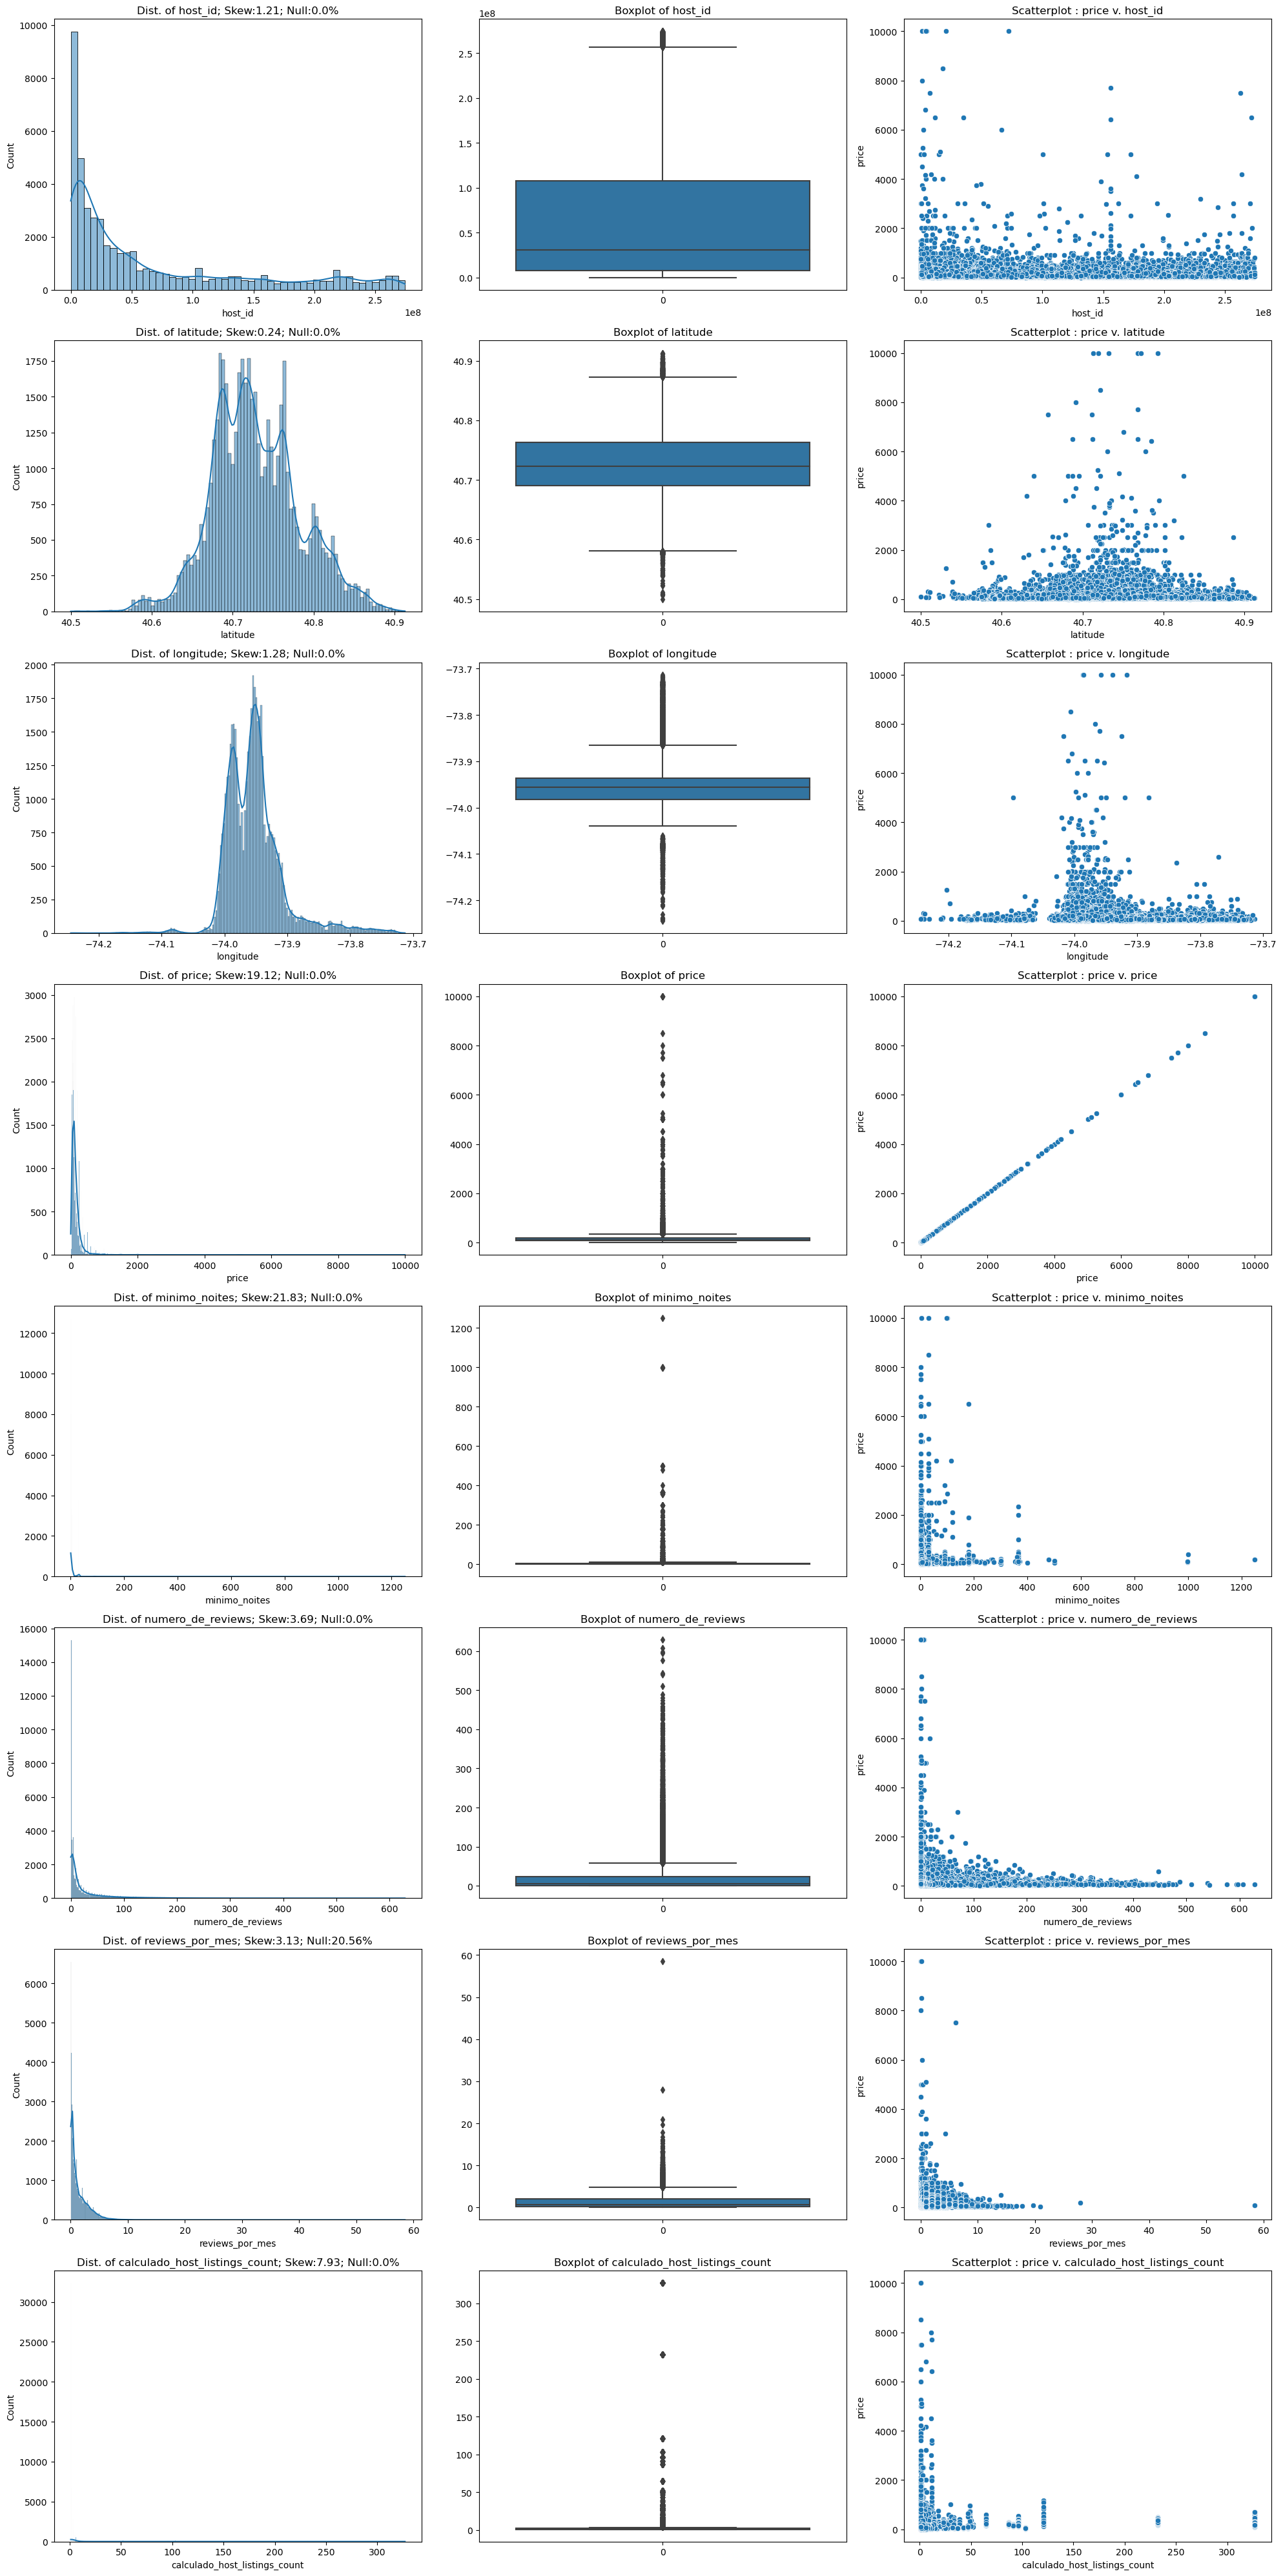

In [6]:
numerical_plot(df, target='price')

É possível verificar indícios da presença de outliers. Olhe por exemplo as variáveis price, minimum_nights e calculated_host_listings_count.

Outra maneira de confirmar os outliers é pelo describe()

In [7]:
df[['price', 'minimo_noites', 'numero_de_reviews', 'calculado_host_listings_count', 'disponibilidade_365']].describe().T

,count,mean,std,min,25%,50%,75%,max
price,48894.0,152.720763,240.156625,0.0,69.0,106.0,175.0,10000.0
minimo_noites,48894.0,7.030085,20.510741,1.0,1.0,3.0,5.0,1250.0
numero_de_reviews,48894.0,23.274758,44.550991,0.0,1.0,5.0,24.0,629.0
calculado_host_listings_count,48894.0,7.144005,32.952855,1.0,1.0,1.0,2.0,327.0
disponibilidade_365,48894.0,112.776169,131.618692,0.0,0.0,45.0,227.0,365.0


Olhando o resumo estatístico e os gráficos acima, podemos confirmar algumas hipóteses como:

* A variável preço (`price`) possui 75% do valor abaixo de 175 dólares, porém seu valor máximo é 10000 dólares. Outro problema com esta mesma variável é que seu valor mínimo é zero, e esse valor não faz nenhum sentido para o aluguel de um imóvel.
* A quantidade mínima de noites (`minimum_nights`) é de até 50 noites para 75% das entradas, porém seu valor máximo é de 1250 noites.
* Os valores acima de 30 noites para a variável minimum_nightssão insignificantes e atrapalham a visualização dos histogramas gerados. O mesmo acontece com os valores acima de 1000 dólares para a variável price.

## Vejamos mais a fundo as variáveis

### **- Qual a correlação existente entre as variáveis**?

C:\Users\arsnf\AppData\Local\Temp\ipykernel_19224\2930538726.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


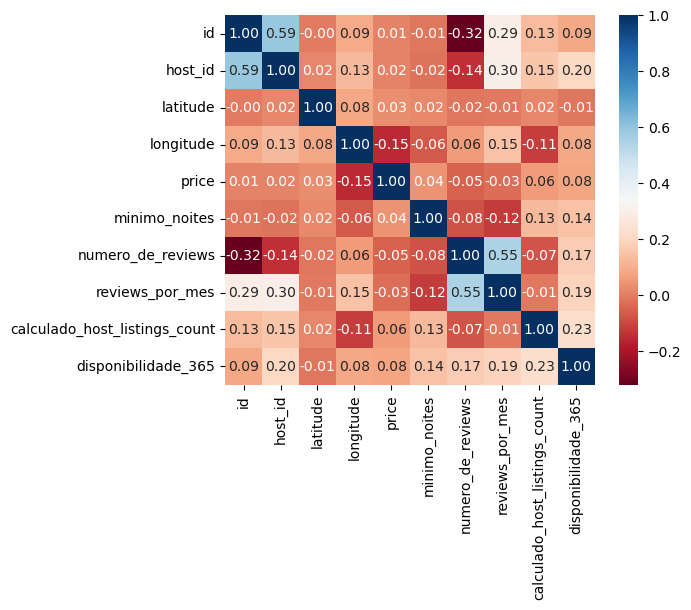

In [8]:
# criar uma matriz de correlação
corr = df.corr()
sns.heatmap(corr, cmap='RdBu', fmt='.2f', square=True, linecolor='white', annot=True);

Pode-se concluir que não há grandes correlações entre diferentes variáveis para este *data frame* específico. O maior valor (0,55) de correlação apresentado na matriz foi entre as variáveis `number_of_reviews` e `reviews_per_month`, que possuem uma correlação óbvia, por uma delas se tratar de um número total de reviews e a outra é expressa em taxa de reviews por mês.

### **- Qual o tipo de imóvel mais alugado? E o de maior receita?**

A coluna da variável `room_type` indica o tipo de locação que está anunciada.

In [9]:
room_type = df.groupby("room_type").id.count().sort_values(ascending=False)
room_type = room_type.reset_index()
room_type.rename(columns={"id":"count"}, inplace=True)
room_type["percent"]=round(room_type["count"] / room_type["count"].sum()*100,2)

room_type["receita"] = df.groupby("room_type").sum().price.values
room_type["receita_room"] =round(room_type["receita"] / room_type["receita"].sum()*100,2)
room_type["tkt"] = round(room_type["receita"] / room_type["count"],2)
room_type

C:\Users\arsnf\AppData\Local\Temp\ipykernel_19224\3611235023.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  room_type["receita"] = df.groupby("room_type").sum().price.values


,room_type,count,percent,receita,receita_room,tkt
0,Entire home/apt,25409,51.97,5381480,72.07,211.79
1,Private room,22325,45.66,2004301,26.84,89.78
2,Shared room,1160,2.37,81348,1.09,70.13


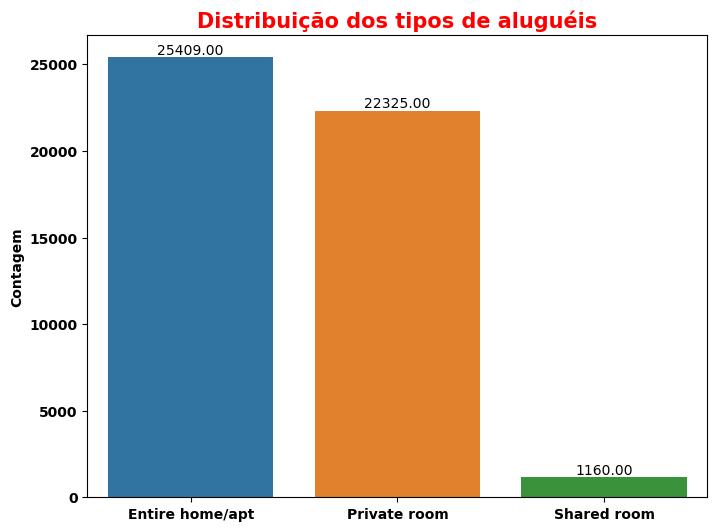

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

# add the plot
sns.countplot(df, x = 'room_type')
plt.title("Distribuição dos tipos de aluguéis", weight="bold", c="red", fontsize=15)
plt.xlabel("",weight="bold",c="k")
plt.xticks(rotation=0, weight="bold")
plt.ylabel("Contagem",weight= "bold",c="k")
plt.yticks(weight="bold")

# add the annotation
ax.bar_label(ax.containers[-1], fmt='\n%.2f', label_type='edge')
plt.show()

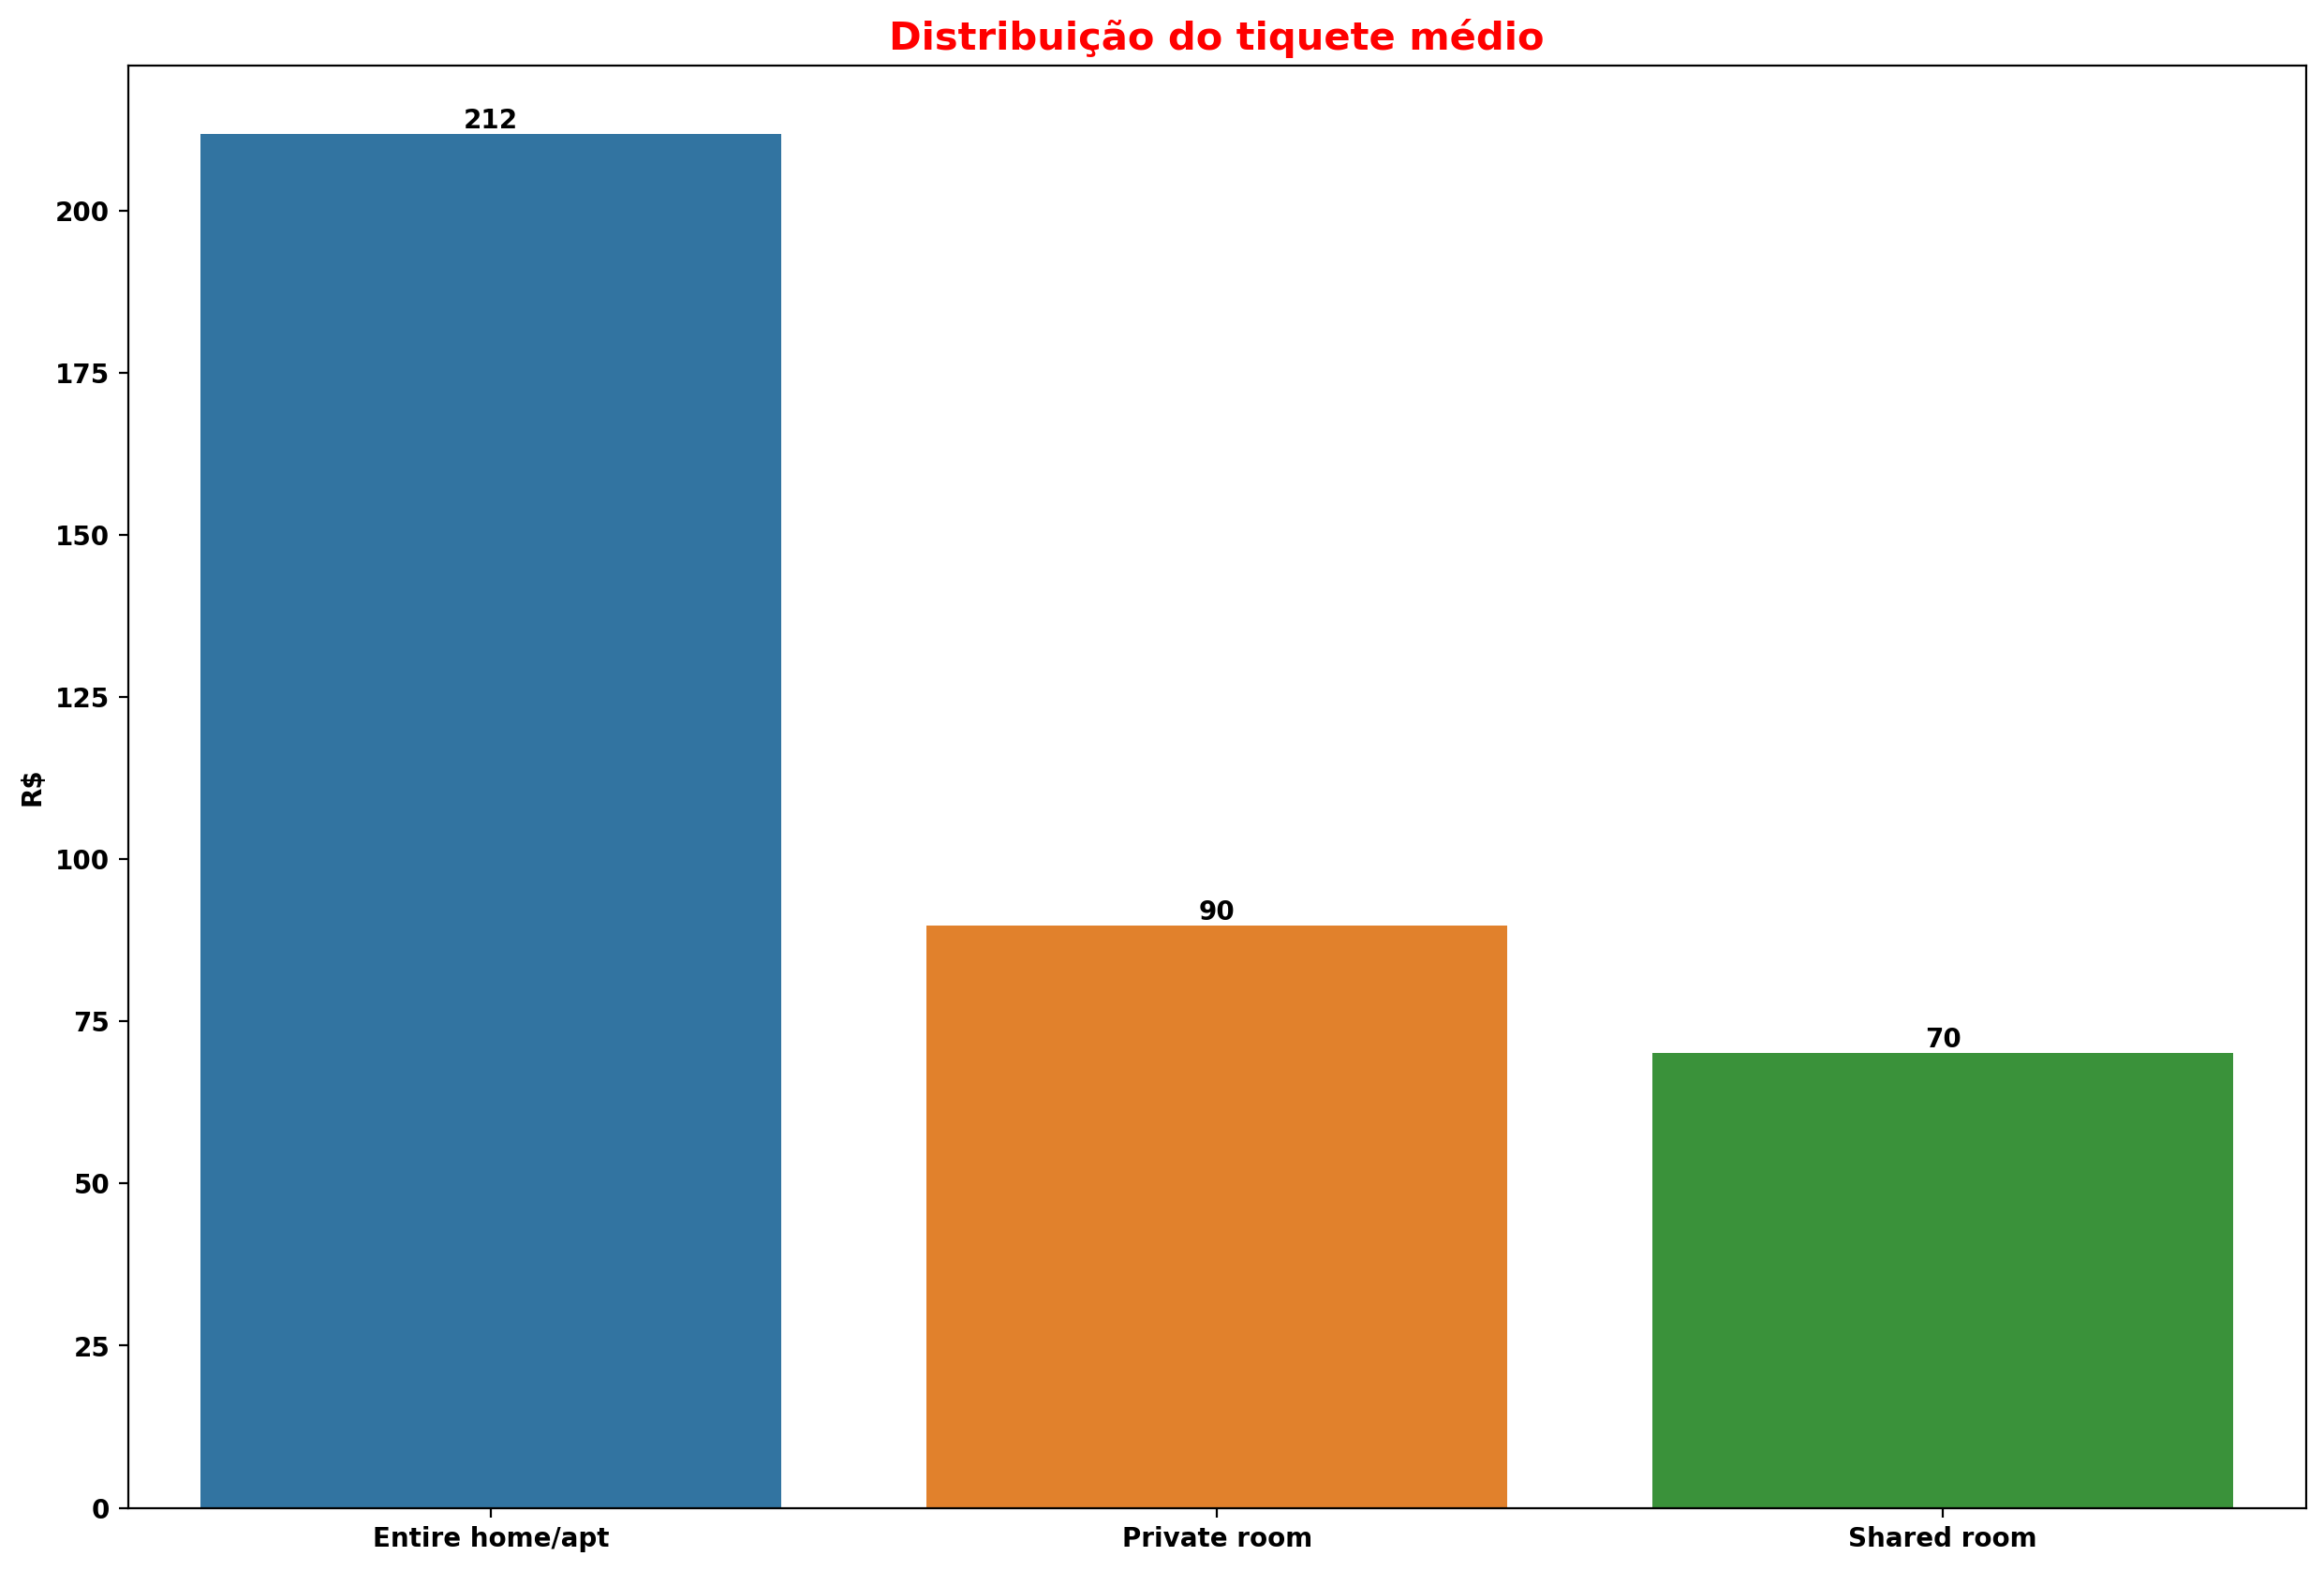

In [11]:
plt.figure(figsize=(15,10),dpi=200),
ax = sns.barplot(x="room_type", y="tkt", data=room_type)
plt.title("Distribuição do tiquete médio", weight="bold", c="red", fontsize=15)
plt.xlabel("",weight="bold",c="k")
plt.xticks(rotation=0, weight="bold")
plt.ylabel("R$",weight= "bold",c="k")
plt.yticks(weight="bold")
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',weight="bold",
                    color= 'black')

plt.show()

### **- Como as avaliações se alteram em relação ao tipo de quarto?**

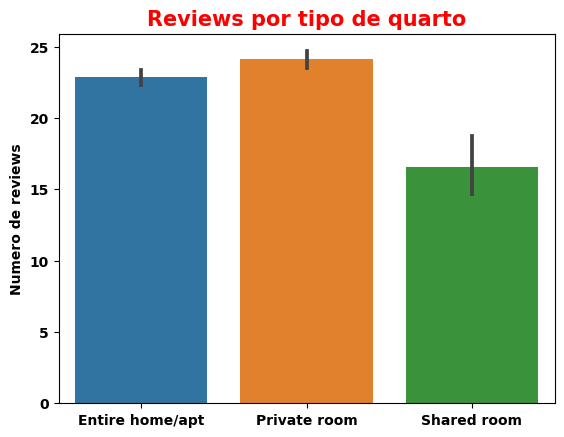

In [12]:
sns.barplot(x="room_type", y="numero_de_reviews", data=df)
plt.title("Reviews por tipo de quarto", weight="bold", c="red", fontsize=15)
plt.xlabel("",weight="bold",c="k")
plt.xticks(rotation=0, weight="bold")
plt.ylabel("Numero de reviews",weight= "bold",c="k")
plt.yticks(weight="bold")
plt.show()

### **- Qual a localidade mais cara de *Nova York*?**


In [15]:
df.groupby(['bairro']).price.mean().sort_values(ascending=False)[:10]

bairro
Fort Wadsworth       800.000000
Woodrow              700.000000
Tribeca              490.638418
Sea Gate             487.857143
Riverdale            442.090909
Prince's Bay         409.500000
Battery Park City    367.557143
Flatiron District    341.925000
Randall Manor        336.000000
NoHo                 295.717949
Name: price, dtype: float64

C:\Users\arsnf\AppData\Local\Temp\ipykernel_19224\3706066945.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.barplot(df.groupby(['bairro']).mean().reset_index().sort_values('price',ascending=False).head(10), x = 'bairro', y = 'price')


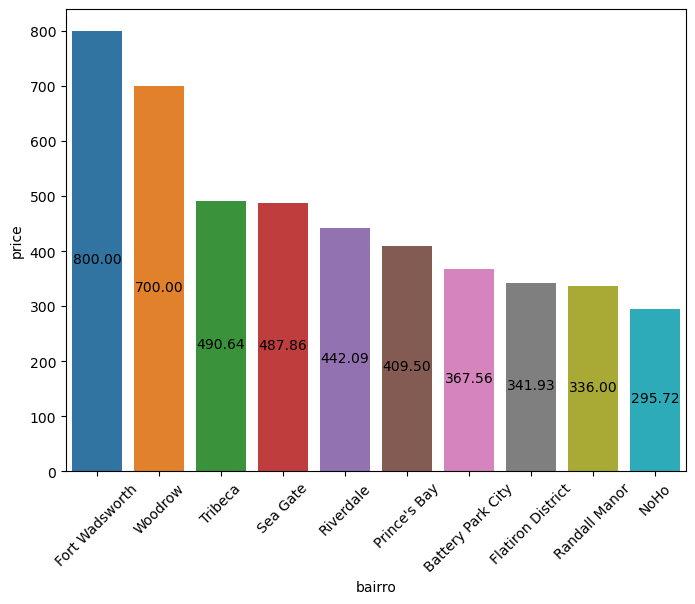

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

# add the plot
sns.barplot(df.groupby(['bairro']).mean().reset_index().sort_values('price',ascending=False).head(10), x = 'bairro', y = 'price')

# add the annotation
ax.bar_label(ax.containers[-1], fmt='\n%.2f', label_type='center')
plt.xticks(rotation = 45)
plt.show()

Deve-se checar também o número de imóveis disponíveis em cada um destes bairros exibidos como os 10 mais caros antes de tomar quaisquer conclusões, pois não seria nada justo dizer que um bairro com apenas um imóvel no Airbnb é o mais caro de *New York City* simplesmente porque este imóvel específico possui um aluguel muito caro.

In [17]:
df[df['bairro'].isin(['Fort Wadsworth', 'Woodrow', 'Tribeca', 'Sea Gate', 
                   'Riverdale', "Prince's Bay", 'Battery Park City',  'Flatiron District'
                    'Randall Manor', 'NoHO'])].groupby('bairro').agg({'price' : ['mean', 'count']})

price      
                         mean count
bairro                             
Battery Park City  367.557143    70
Fort Wadsworth     800.000000     1
Prince's Bay       409.500000     4
Riverdale          442.090909    11
Sea Gate           487.857143     7
Tribeca            490.638418   177
Woodrow            700.000000     1

Podemos desconsiderar completamente os bairros *Fort Wadsworth*, *Prince's Bay*, *Woodrow*, pois todos possuem apenas poucos imóveis listados. Um rank justo para os bairros com os imóveis mais caros seria apenas com os bairros remanescentes na lista, logo o bairro considerado mais caro em média de preços é **Tribeca** com uma média de preços de aproximadamente $ 490,00 em um total de 177 imóveis.

In [18]:
# Vamos observar a média de preços dos 10 distritos mais caros de New York City
df.groupby(['bairro_group']).price.mean().sort_values(ascending=False)[:10]

bairro_group
Manhattan        196.875814
Brooklyn         124.381983
Staten Island    114.812332
Queens            99.517649
Bronx             87.496792
Name: price, dtype: float64

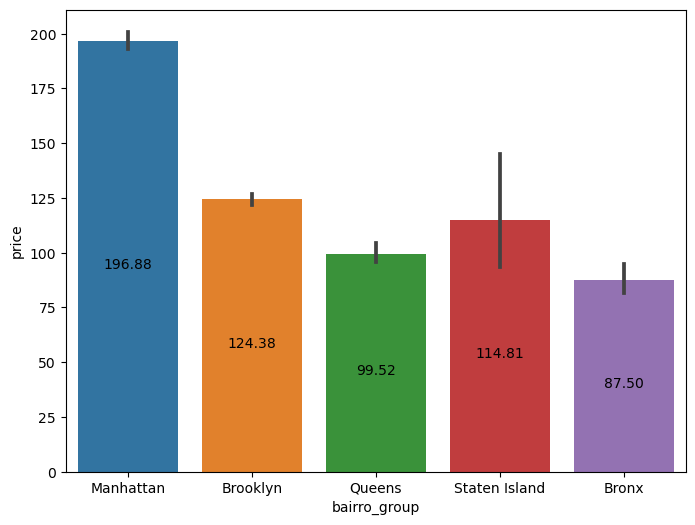

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

# add the plot
sns.barplot(df, x = 'bairro_group', y = 'price')

# add the annotation
ax.bar_label(ax.containers[-1], fmt='\n%.2f', label_type='center')
plt.show()

Entre os distritos de *New York City* temos *Manhattan* como a região mais cara. 

## **- Como as avaliações variam em relação ao bairro?**

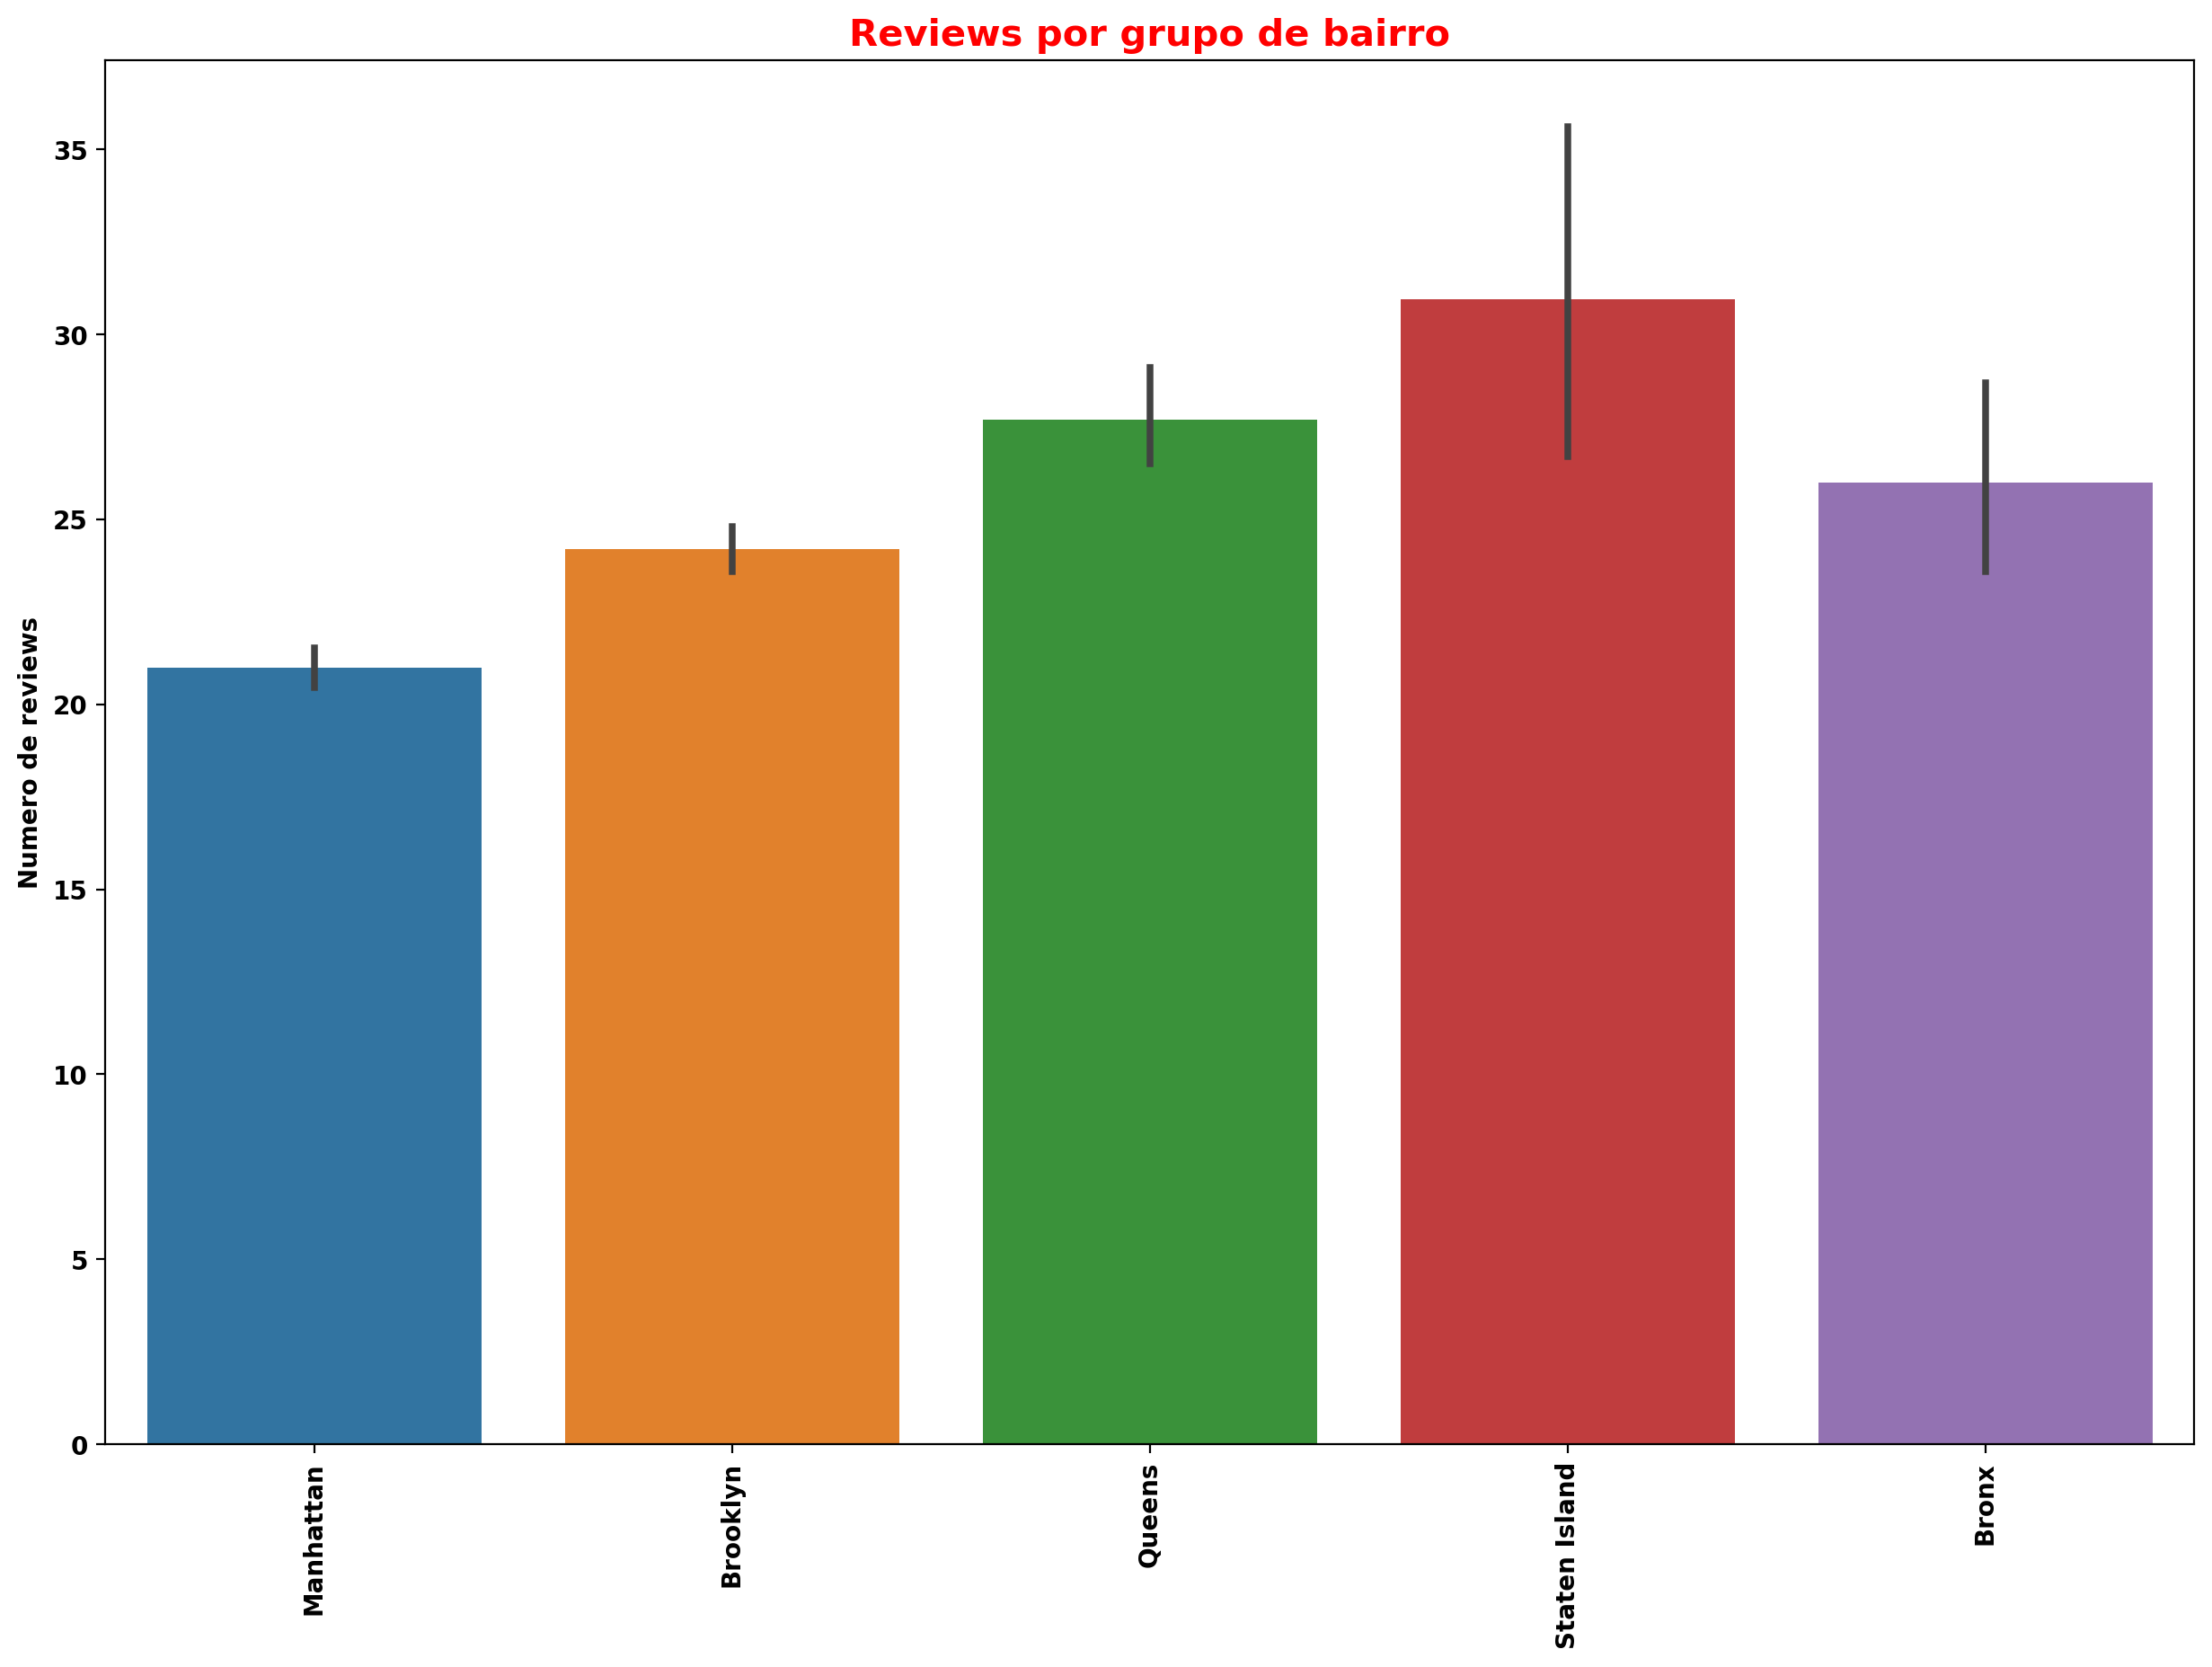

In [20]:
plt.figure(figsize=(15,10),dpi=200)
sns.barplot(x="bairro_group", y="numero_de_reviews", data=df)
plt.title("Reviews por grupo de bairro", weight="bold", c="red", fontsize=15)
plt.xlabel("",weight="bold",c="k")
plt.xticks(rotation=90, weight="bold")
plt.ylabel("Numero de reviews",weight= "bold",c="k")
plt.yticks(weight="bold")
plt.show()

Os bairros mais avaliados também são os mais caros.

## **- Quais tipos de quartos e bairros tem a maior disponibilidade**

In [21]:
ocup_bairro = df.groupby("bairro_group").disponibilidade_365.mean().sort_values(ascending = False).reset_index()
ocup_bairro.head(10)

,bairro_group,disponibilidade_365
0,Staten Island,199.678284
1,Bronx,165.758937
2,Queens,144.451818
3,Manhattan,111.979410
4,Brooklyn,100.219122


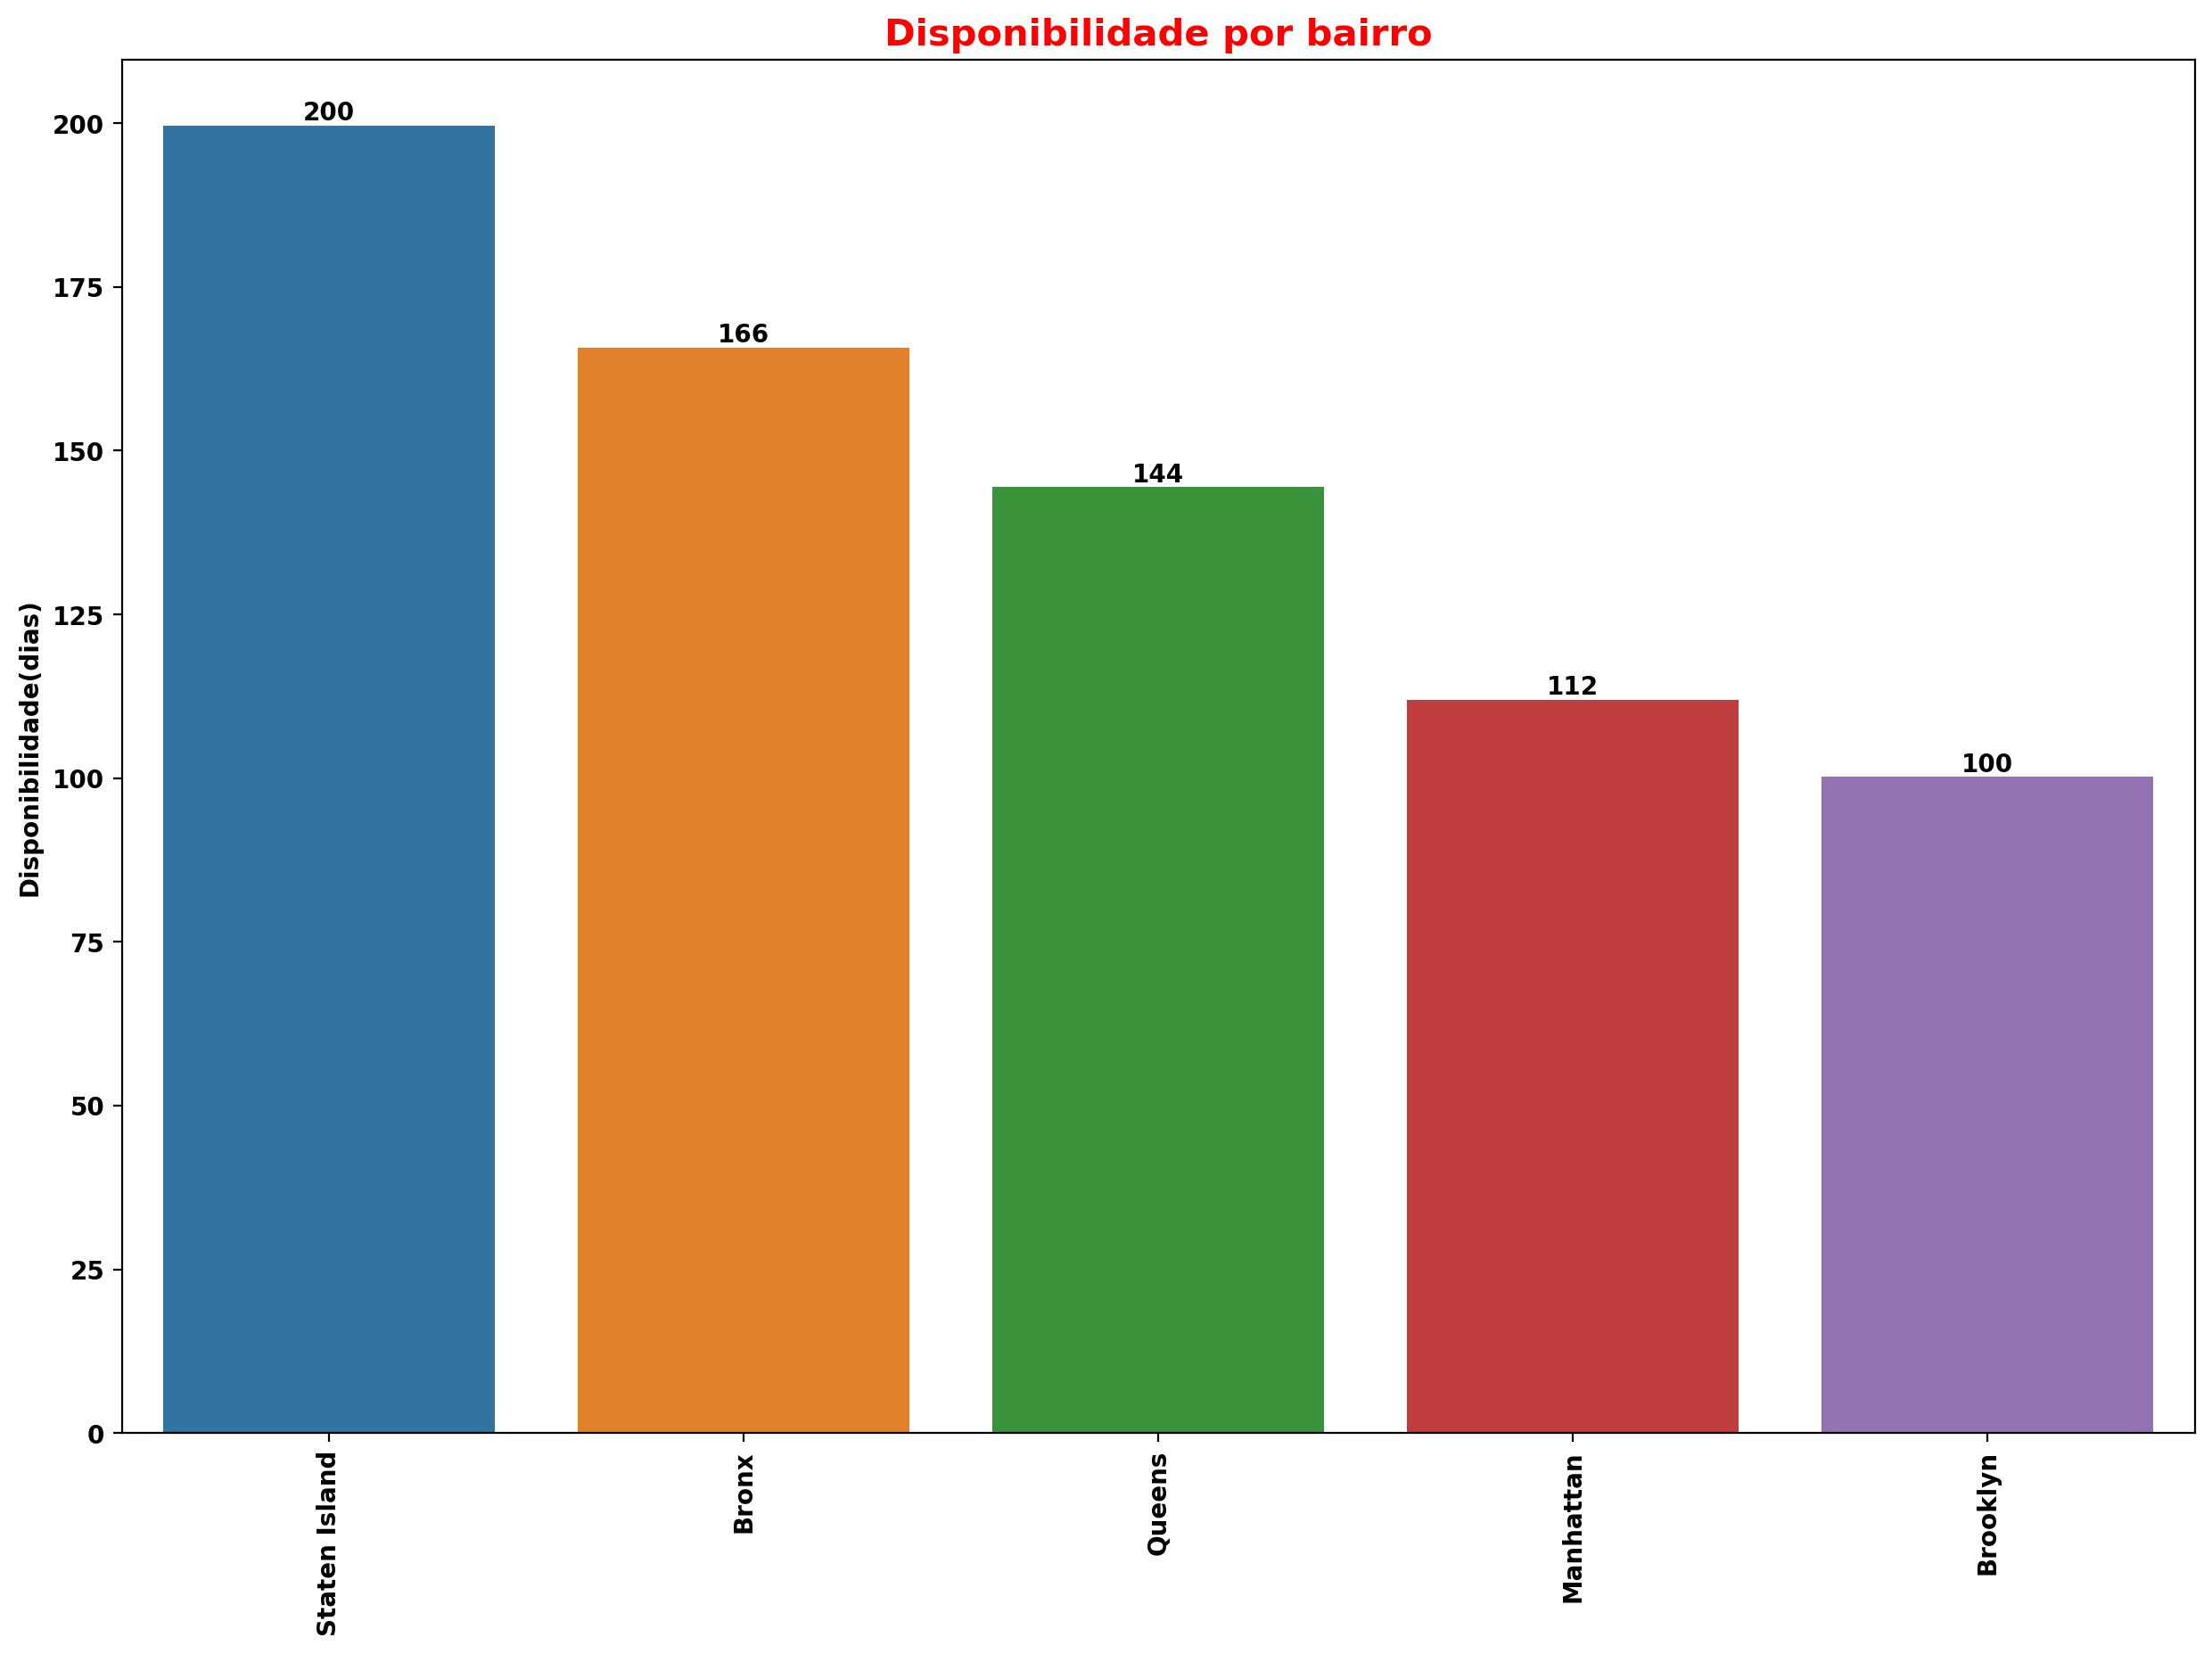

In [22]:
plt.figure(figsize=(15,10),dpi=200),
plt.style.use('default')
ax = sns.barplot(x="bairro_group", y="disponibilidade_365", data=ocup_bairro)
plt.title("Disponibilidade por bairro", weight="bold", c="red", fontsize=15)
plt.xlabel("",weight="bold",c="k")
plt.xticks(rotation=90, weight="bold")
plt.ylabel("Disponibilidade(dias)",weight= "bold",c="k")
plt.yticks(weight="bold")
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', size=10, weight="bold")

plt.show()

In [23]:
ocup_room = df.groupby("room_type").disponibilidade_365.mean().sort_values(ascending = False).reset_index()
ocup_room.head(10)

,room_type,disponibilidade_365
0,Shared room,162.000862
1,Entire home/apt,111.920304
2,Private room,111.192564


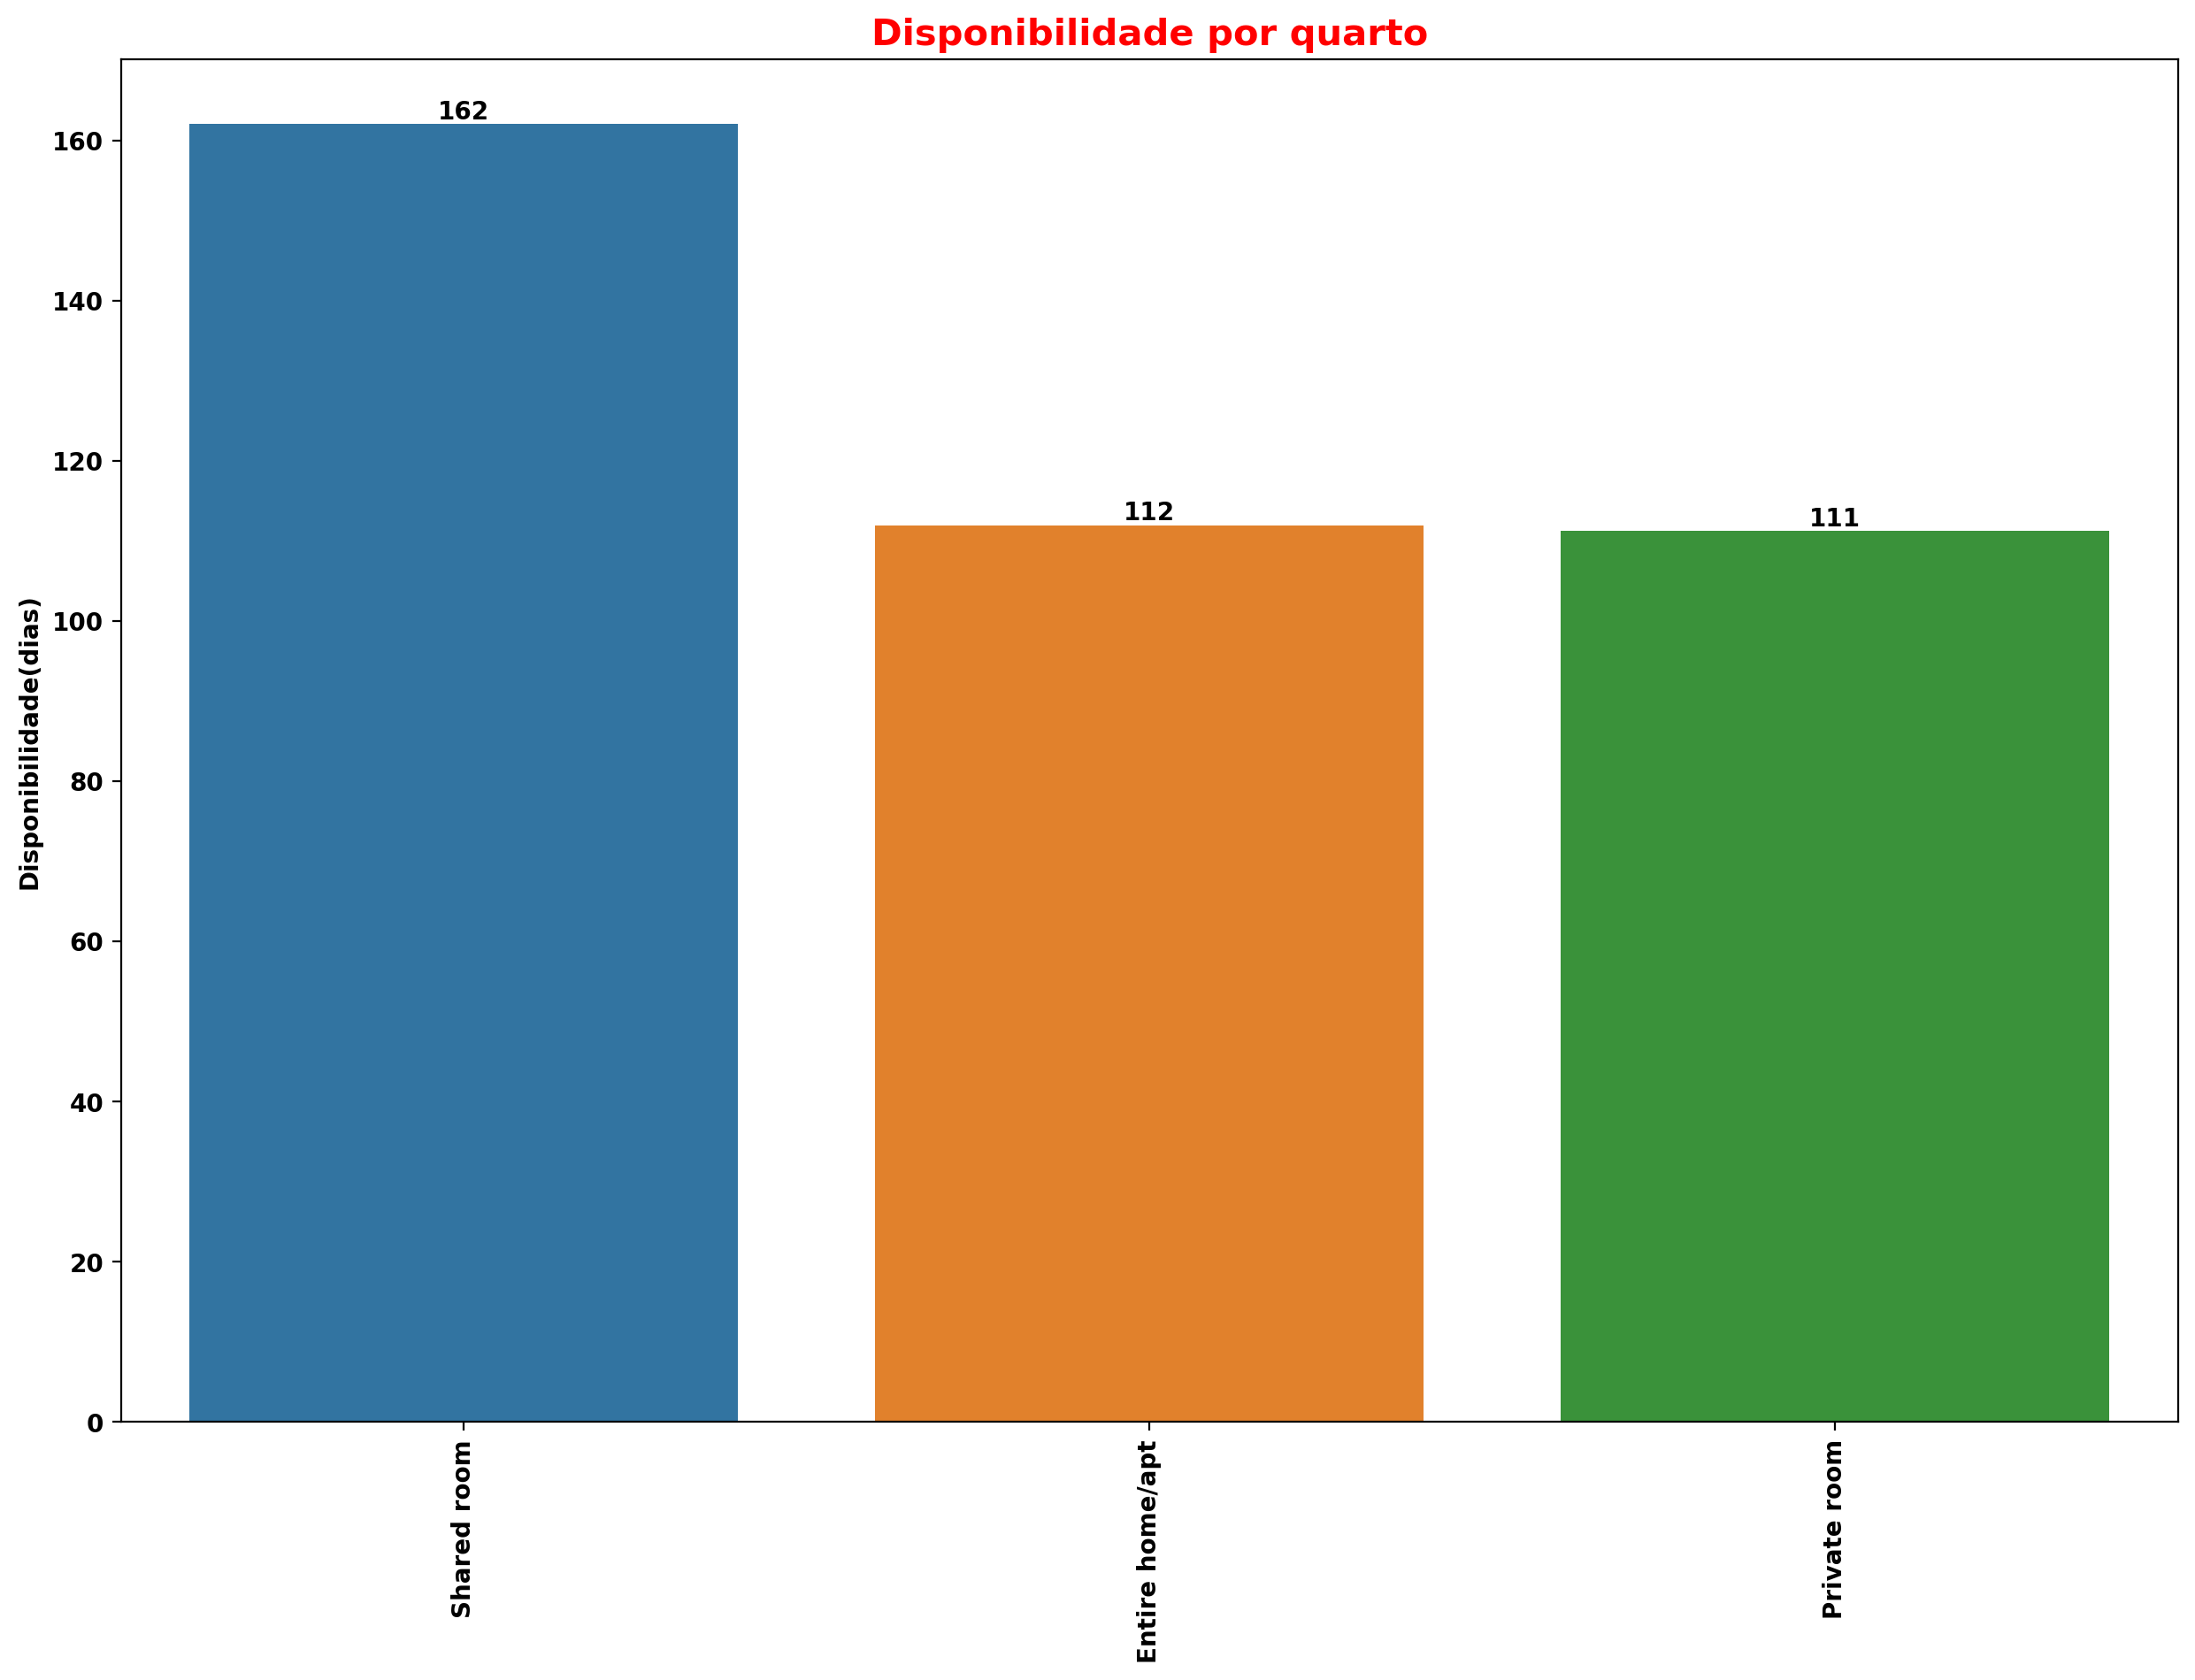

In [24]:
plt.figure(figsize=(15,10),dpi=200),
plt.style.use('default')
ax = sns.barplot(x="room_type", y="disponibilidade_365", data=ocup_room)
plt.title("Disponibilidade por quarto", weight="bold", c="red", fontsize=15)
plt.xlabel("",weight="bold",c="k")
plt.xticks(rotation=90, weight="bold")
plt.ylabel("Disponibilidade(dias)",weight= "bold",c="k")
plt.yticks(weight="bold")
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', size=10, weight="bold")

plt.show()

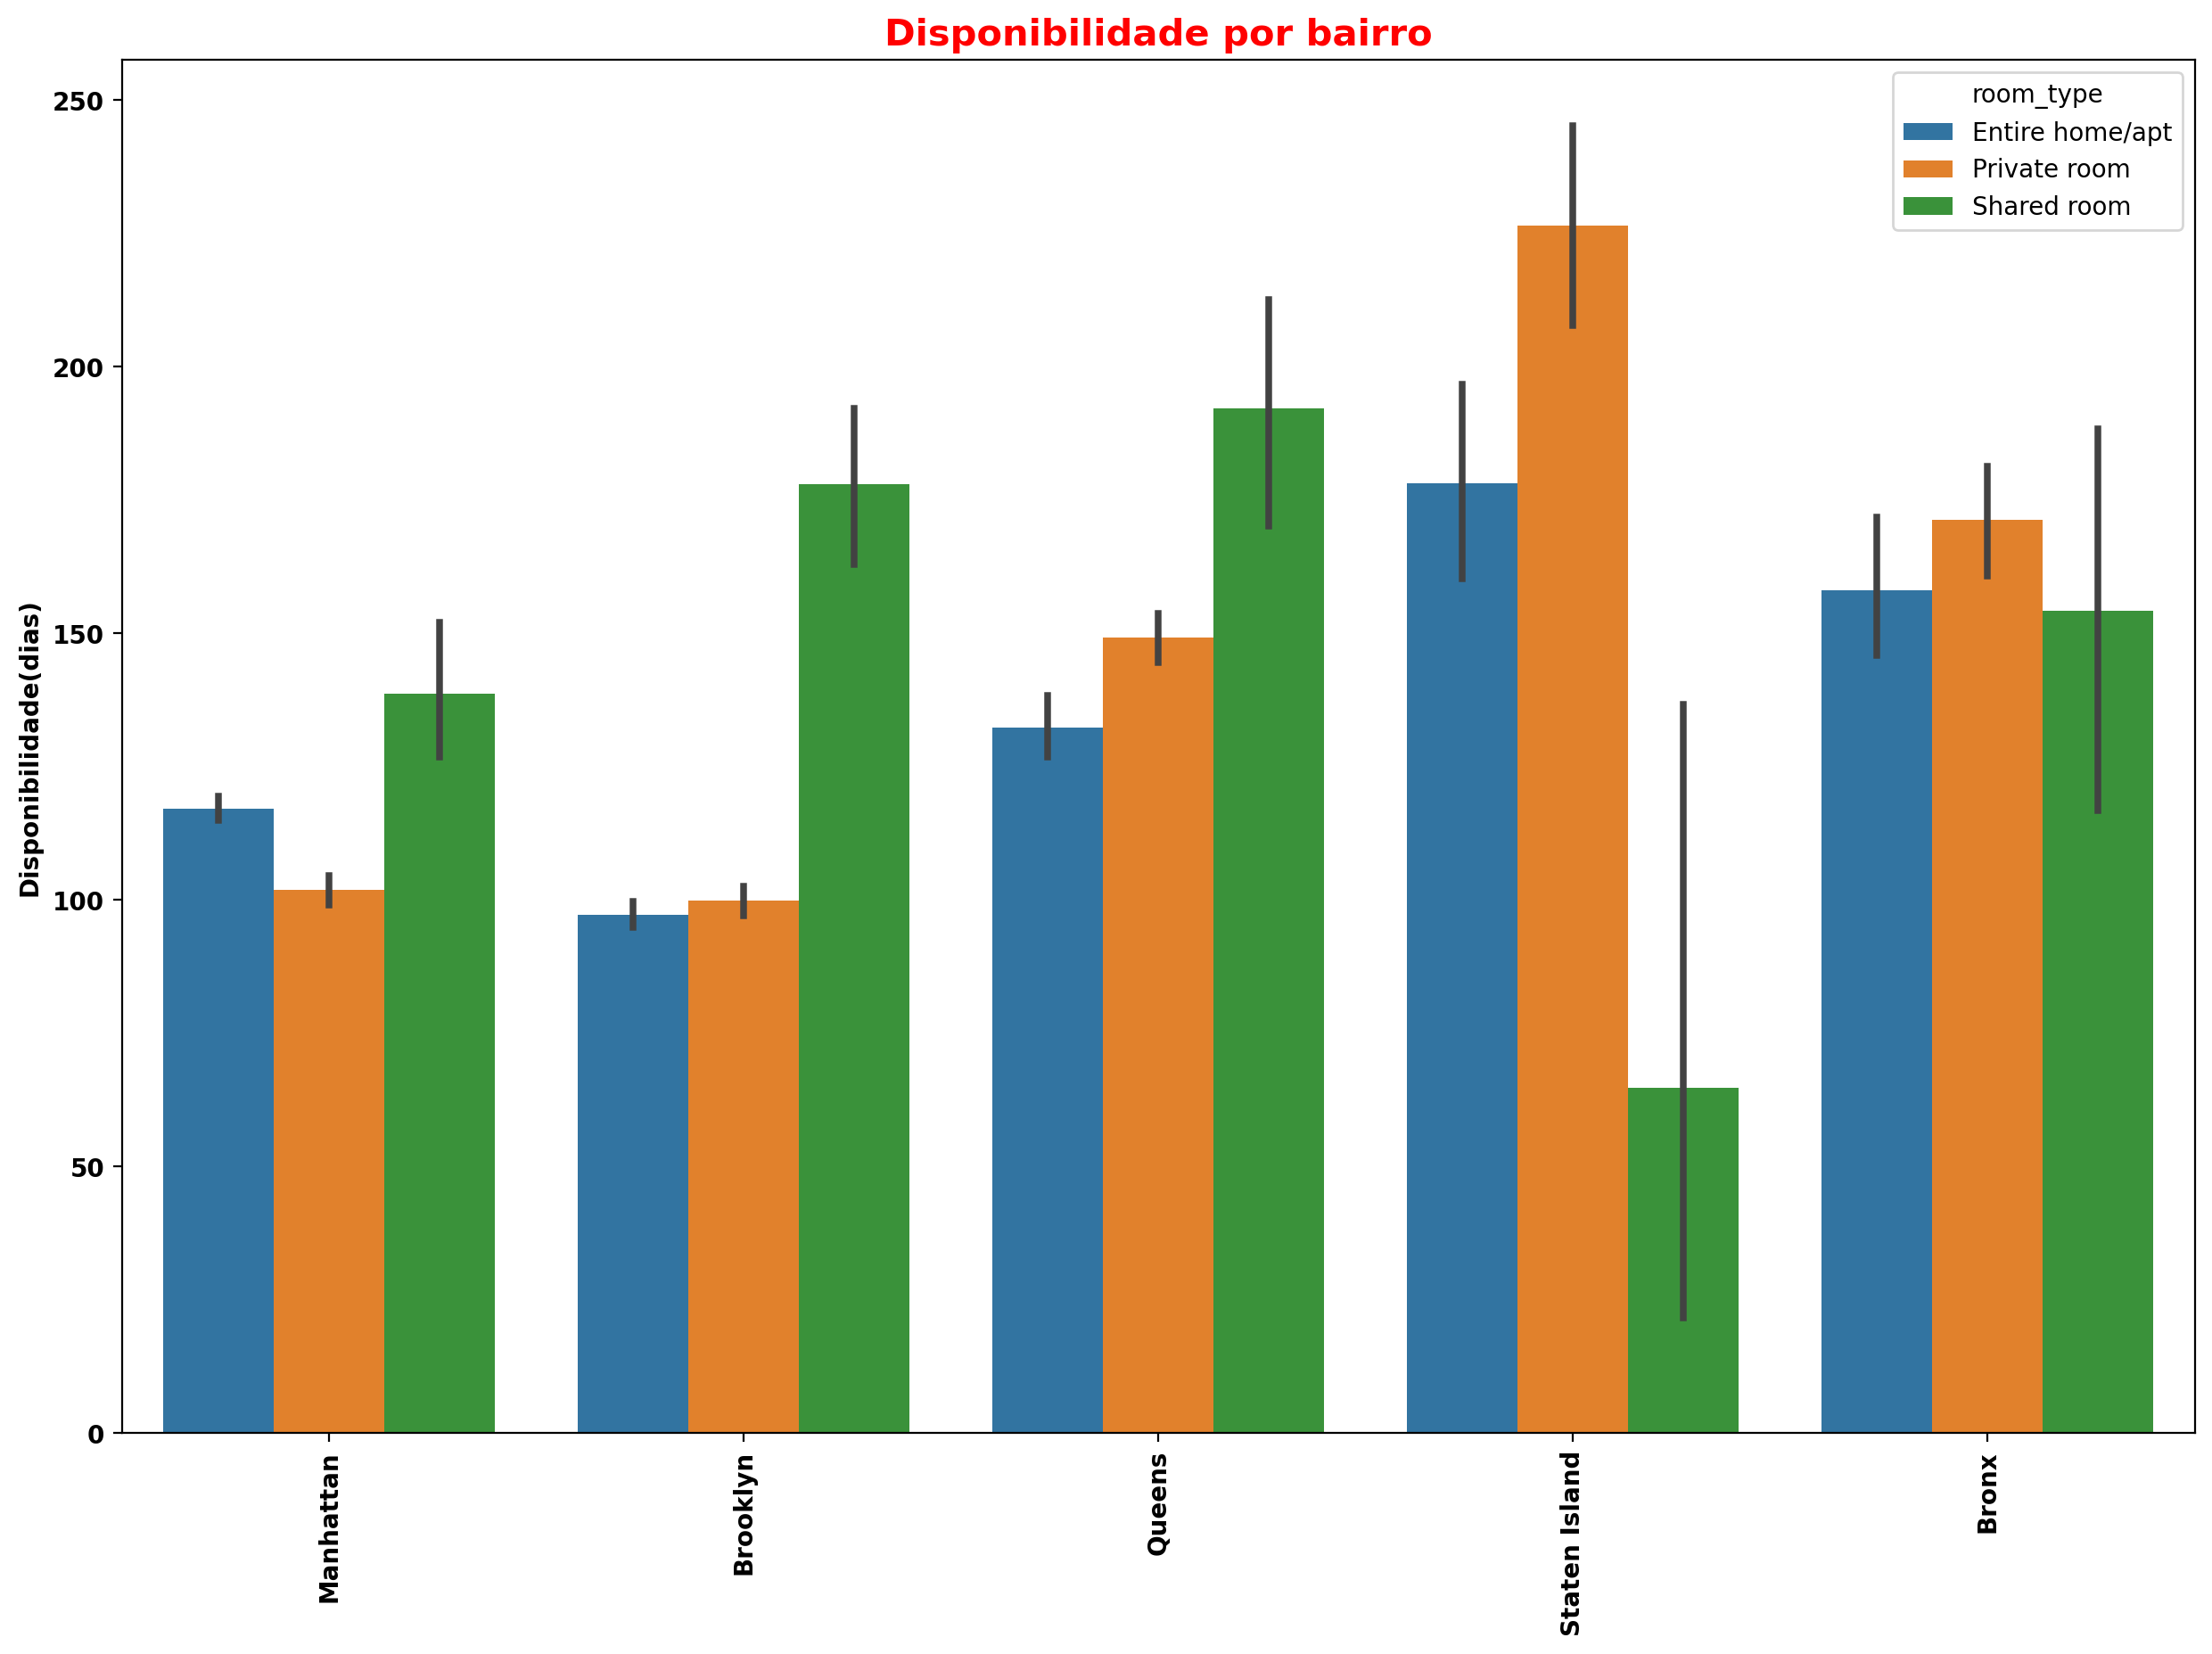

In [25]:
plt.figure(figsize=(15,10),dpi=200),
plt.style.use('default')
ax = sns.barplot(x="bairro_group", y="disponibilidade_365", data=df, hue = 'room_type')
plt.title("Disponibilidade por bairro", weight="bold", c="red", fontsize=15)
plt.xlabel("",weight="bold",c="k")
plt.xticks(rotation=90, weight="bold")
plt.ylabel("Disponibilidade(dias)",weight= "bold",c="k")
plt.yticks(weight="bold")

plt.show()

Staten Island e Bronx aparecem como duas opções com preços médios e ofertas de apartamentos e quartos

### **-  O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço??**

In [26]:
minimo_ok = df[df['minimo_noites'] <=365]
minimo_ok.groupby(pd.cut(minimo_ok['minimo_noites'],[1, 10,20,30,50, 100, 200, 365])).agg({'price' : ['mean', 'count']})

price       
                     mean  count
minimo_noites                   
(1, 10]        152.733029  29535
(10, 20]       117.290840   1310
(20, 30]       178.419158   4583
(30, 50]       185.282313    294
(50, 100]      276.096774    279
(100, 200]     302.295238    105
(200, 365]     241.090909     55

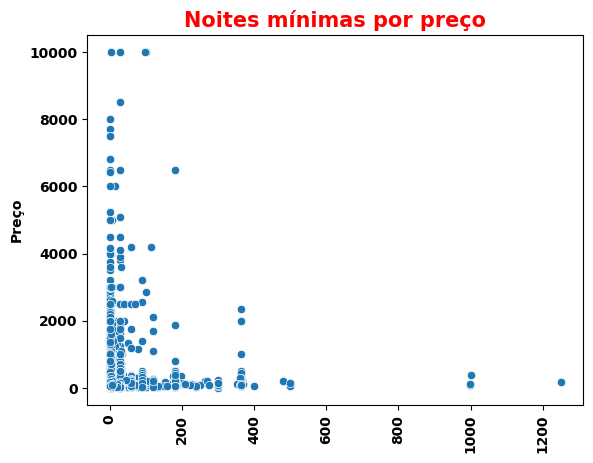

In [76]:
sns.scatterplot(df, x = 'minimo_noites', y = 'price')
plt.title("Noites mínimas por preço", weight="bold", c="red", fontsize=15)
plt.xlabel("",weight="bold",c="k")
plt.xticks(rotation=90, weight="bold")
plt.ylabel("Preço",weight= "bold",c="k")
plt.yticks(weight="bold")
plt.show()

In [70]:
disp_ok = df[(df['disponibilidade_365'] <=365) & (df['disponibilidade_365'] > 0)]
disp_ok.groupby(pd.cut(disp_ok['disponibilidade_365'],[1, 10,20,30,50, 100, 200, 365])).agg({'price' : ['mean', 'count']})

price       
                           mean  count
disponibilidade_365                   
(1, 10]              136.308530   2204
(10, 20]             140.132761   1514
(20, 30]             144.527875   1148
(30, 50]             138.494107   2121
(50, 100]            148.700950   4842
(100, 200]           161.136568   5792
(200, 365]           180.293729  13332

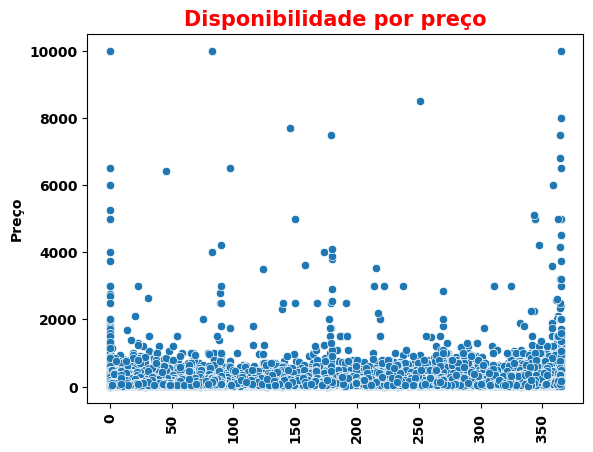

In [74]:
sns.scatterplot(df, x = 'disponibilidade_365', y = 'price')
plt.title("Disponibilidade por preço", weight="bold", c="red", fontsize=15)
plt.xlabel("",weight="bold",c="k")
plt.xticks(rotation=90, weight="bold")
plt.ylabel("Preço",weight= "bold",c="k")
plt.yticks(weight="bold")
plt.show()

Aparentemente a disponibilidade e o mínimo de noites não afetam o preço

## - Relação entre bairro, disponibilidade e preços

Vamos criar uma relação entre custo e benefício para bairros e quartos

In [27]:
room_type["disponibilidade"]= ocup_room.disponibilidade_365.values
room_type["receita_por_disp"]=round(room_type["receita"] / room_type["disponibilidade"],2)

room_type

,room_type,count,percent,receita,receita_room,tkt,disponibilidade,receita_por_disp
0,Entire home/apt,25409,51.97,5381480,72.07,211.79,162.000862,33218.84
1,Private room,22325,45.66,2004301,26.84,89.78,111.920304,17908.29
2,Shared room,1160,2.37,81348,1.09,70.13,111.192564,731.60


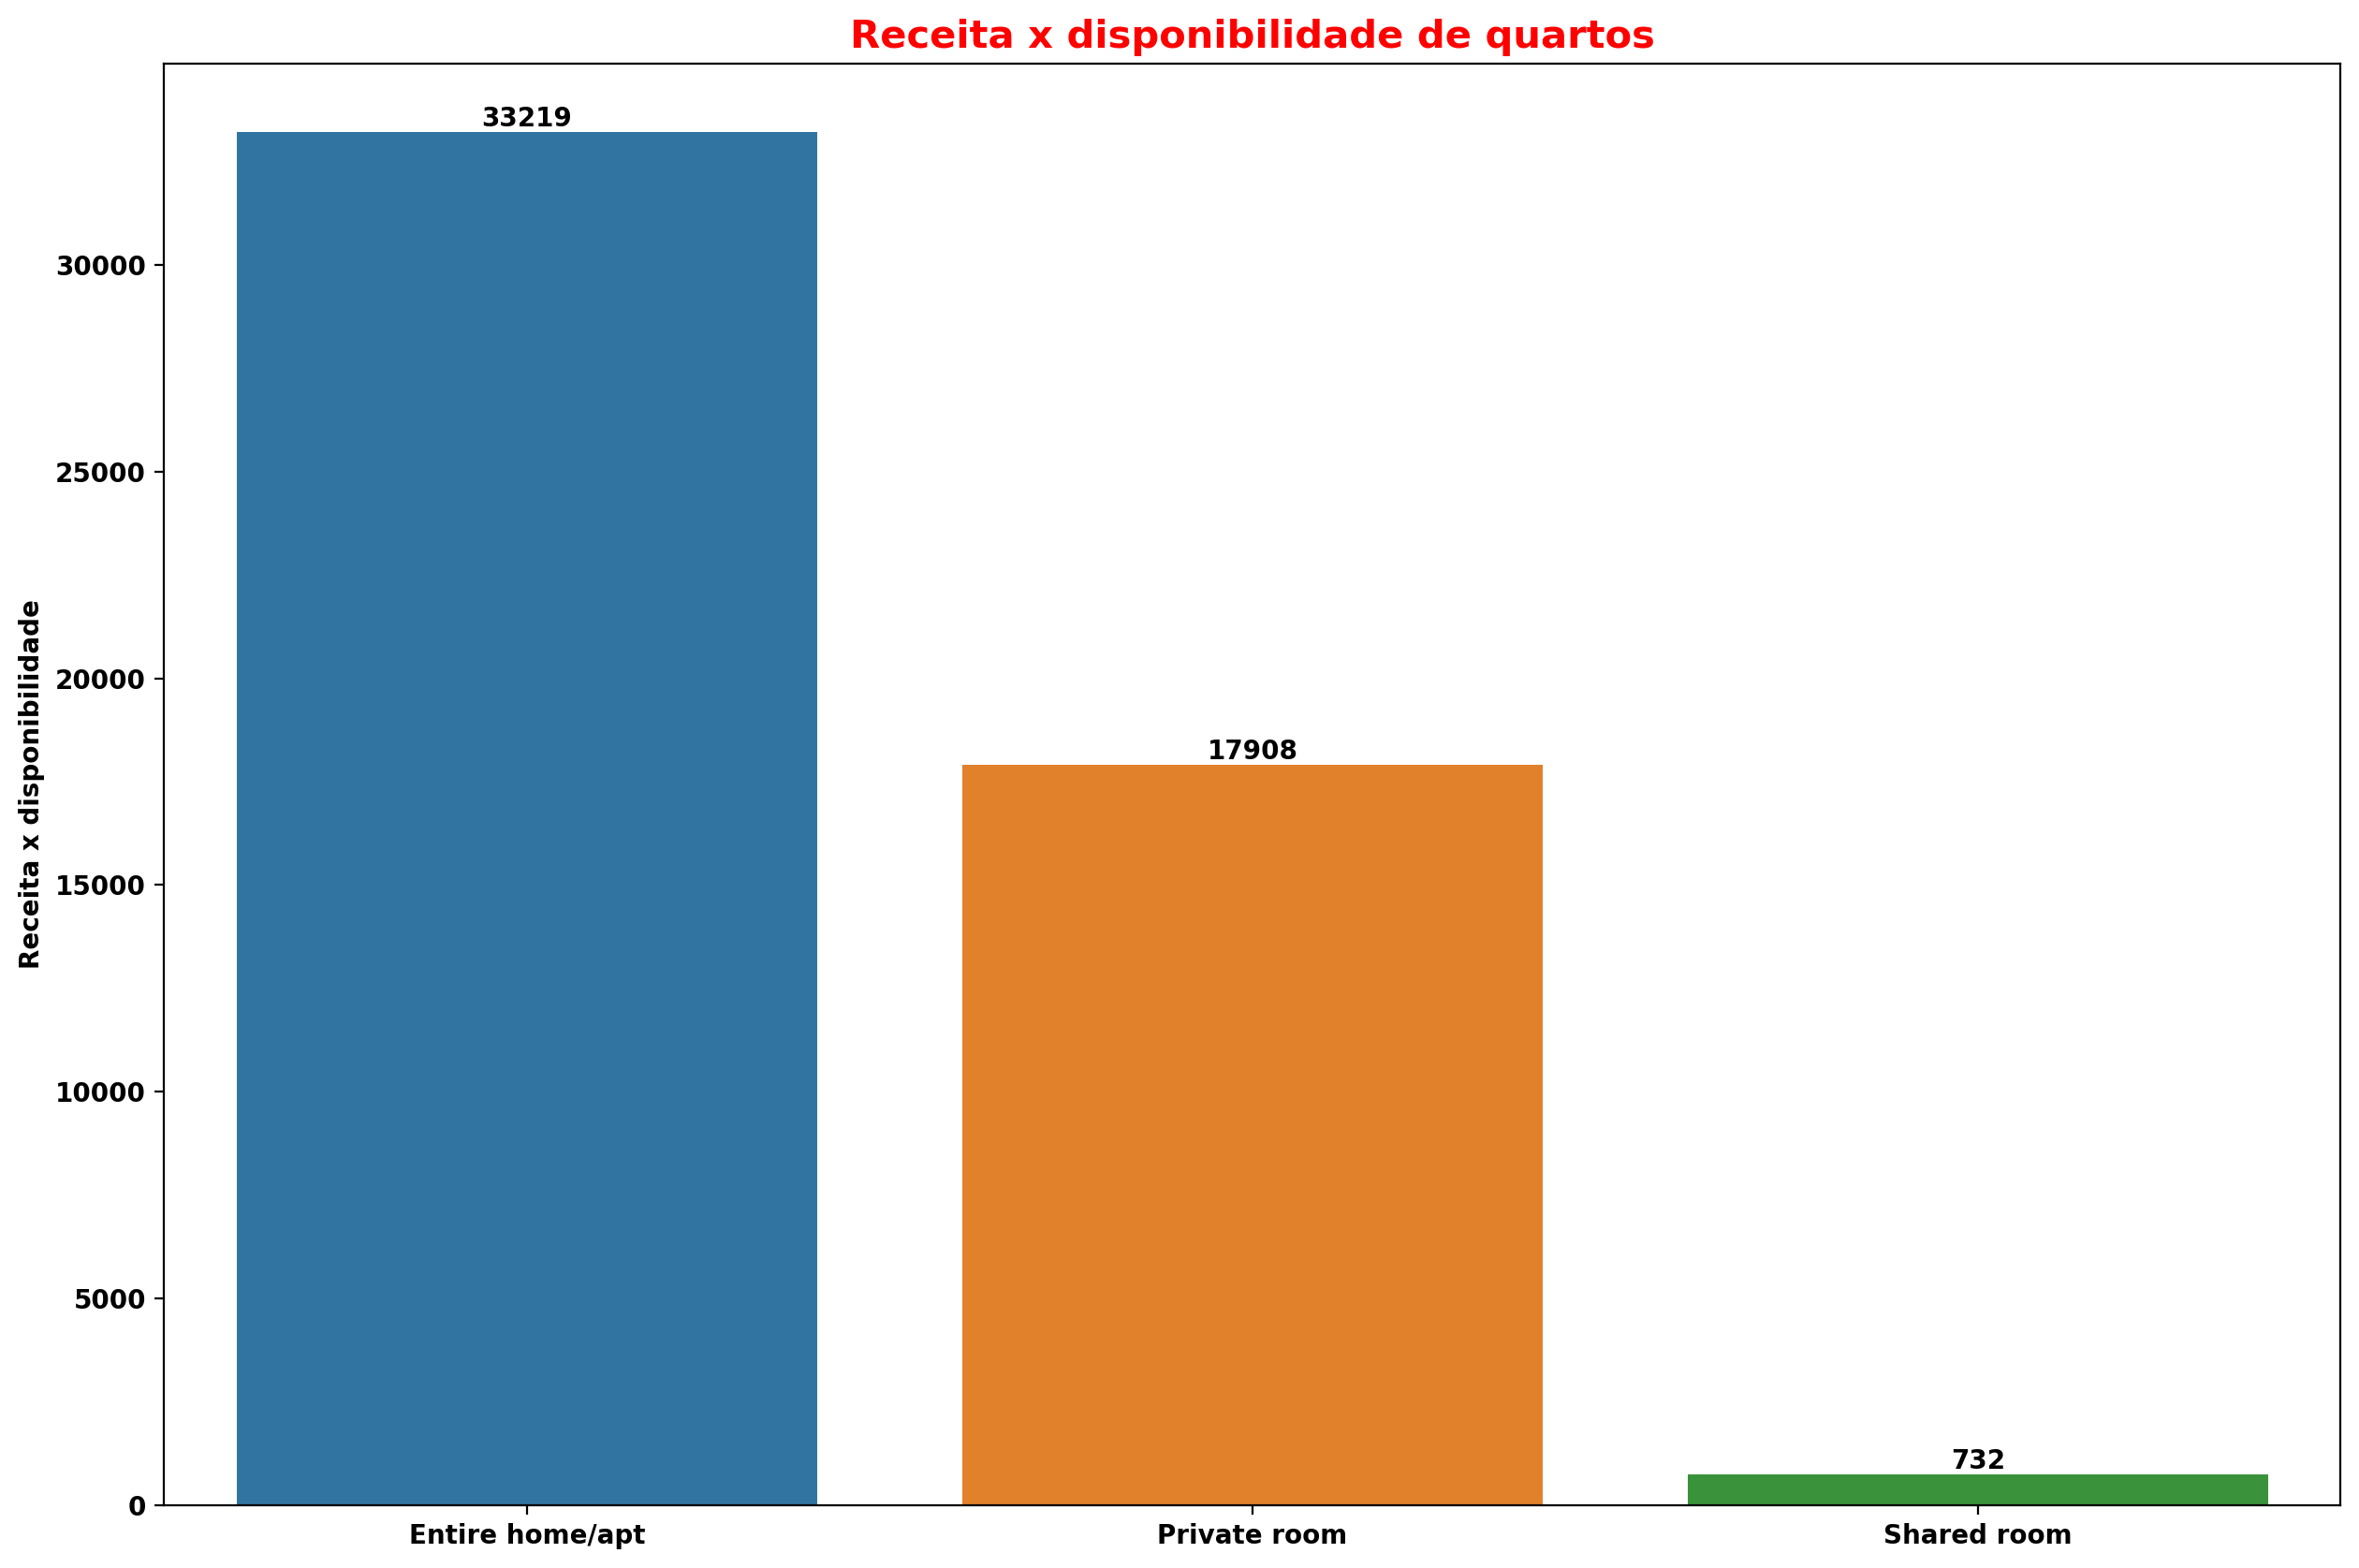

In [28]:
plt.figure(figsize=(15,10),dpi=200),
ax = sns.barplot(x="room_type", y="receita_por_disp", data=room_type)
plt.title("Receita x disponibilidade de quartos", weight="bold", c="red", fontsize=15)
plt.xlabel("",weight="bold",c="k")
plt.xticks(rotation=0, weight="bold")
plt.ylabel("Receita x disponibilidade",weight= "bold",c="k")
plt.yticks(weight="bold")
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',weight="bold",
                    color= 'black')

plt.show()

In [29]:
bairro_group = df.groupby("bairro_group").id.count().sort_values(ascending=False).reset_index()
bairro_group.rename(columns={"id":"count"}, inplace=True)
bairro_group["percent"] = round(bairro_group["count"]/bairro_group["count"].sum()*100,2)
bairro_group['receita'] = df.groupby("bairro_group").price.mean().sort_values(ascending=False).values
bairro_group["disponibilidade"] = ocup_bairro.disponibilidade_365.values
bairro_group["receita_por_disp"]=round(bairro_group["receita"] / bairro_group["disponibilidade"],2)
bairro_group

,bairro_group,count,percent,receita,disponibilidade,receita_por_disp
0,Manhattan,21661,44.30,196.875814,199.678284,0.99
1,Brooklyn,20103,41.12,124.381983,165.758937,0.75
2,Queens,5666,11.59,114.812332,144.451818,0.79
3,Bronx,1091,2.23,99.517649,111.979410,0.89
4,Staten Island,373,0.76,87.496792,100.219122,0.87


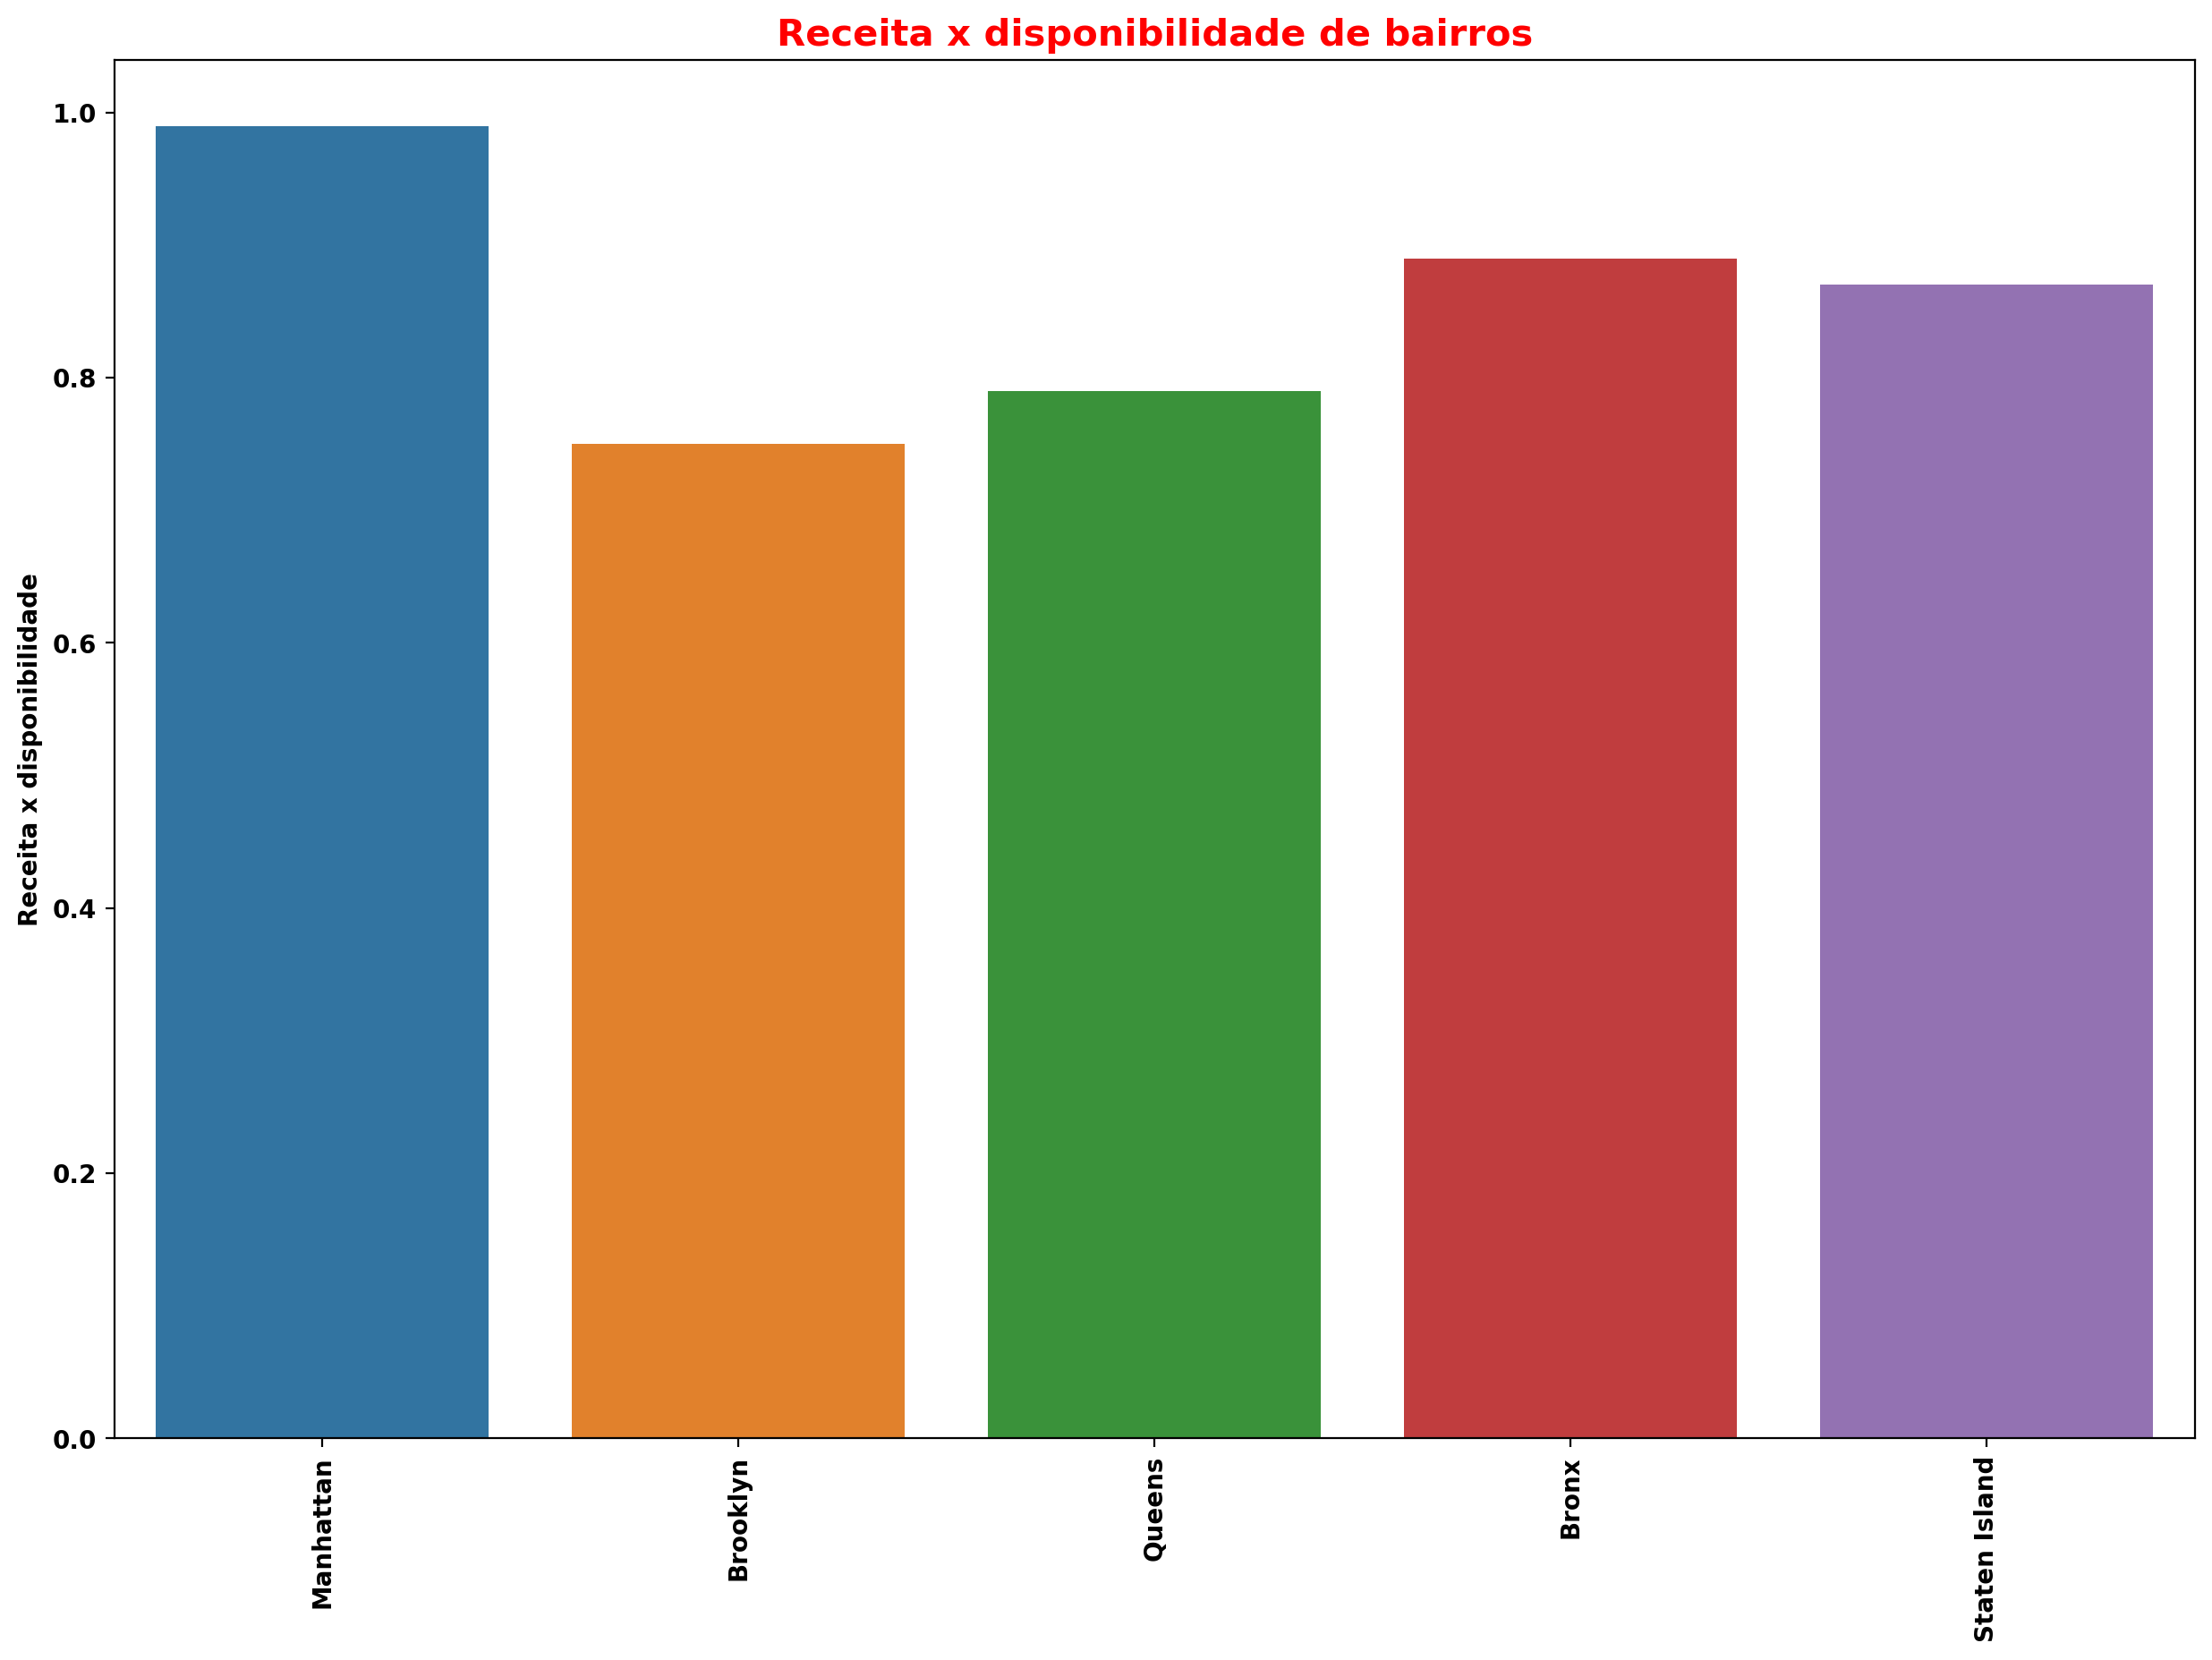

In [30]:
plt.figure(figsize=(15,10),dpi=200),
ax = sns.barplot(x="bairro_group", y="receita_por_disp", data = bairro_group)
plt.title("Receita x disponibilidade de bairros", weight="bold", c="red", fontsize=15)
plt.xlabel("",weight="bold",c="k")
plt.xticks(rotation=90, weight="bold")
plt.ylabel("Receita x disponibilidade",weight= "bold",c="k")
plt.yticks(weight="bold")

plt.show()

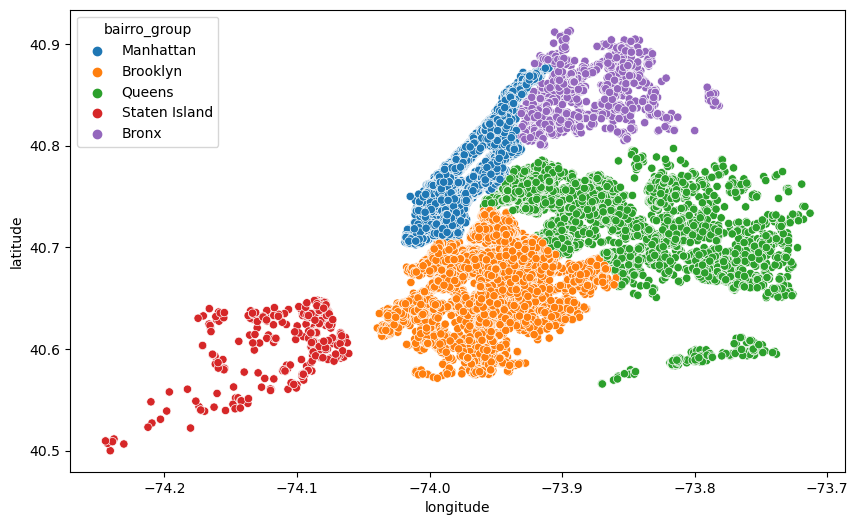

In [31]:
plt.figure(figsize=(10,6))
sns.scatterplot(df, x = df.longitude, y = df.latitude, hue=df.bairro_group)
plt.show()

a. Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

Os bairros Staten Island e Bronx aparecem como boas oprtunidades já que ainda não estão saturados e tem bom faturamento/disponibilidade. Esses dois bairros, sendo Staten Island a opção mais interessante, são mais indicados para comprar um imóvel, dado sua disponibilidade, oferta e valor.

## **- Os preços mudam com as reviews?**

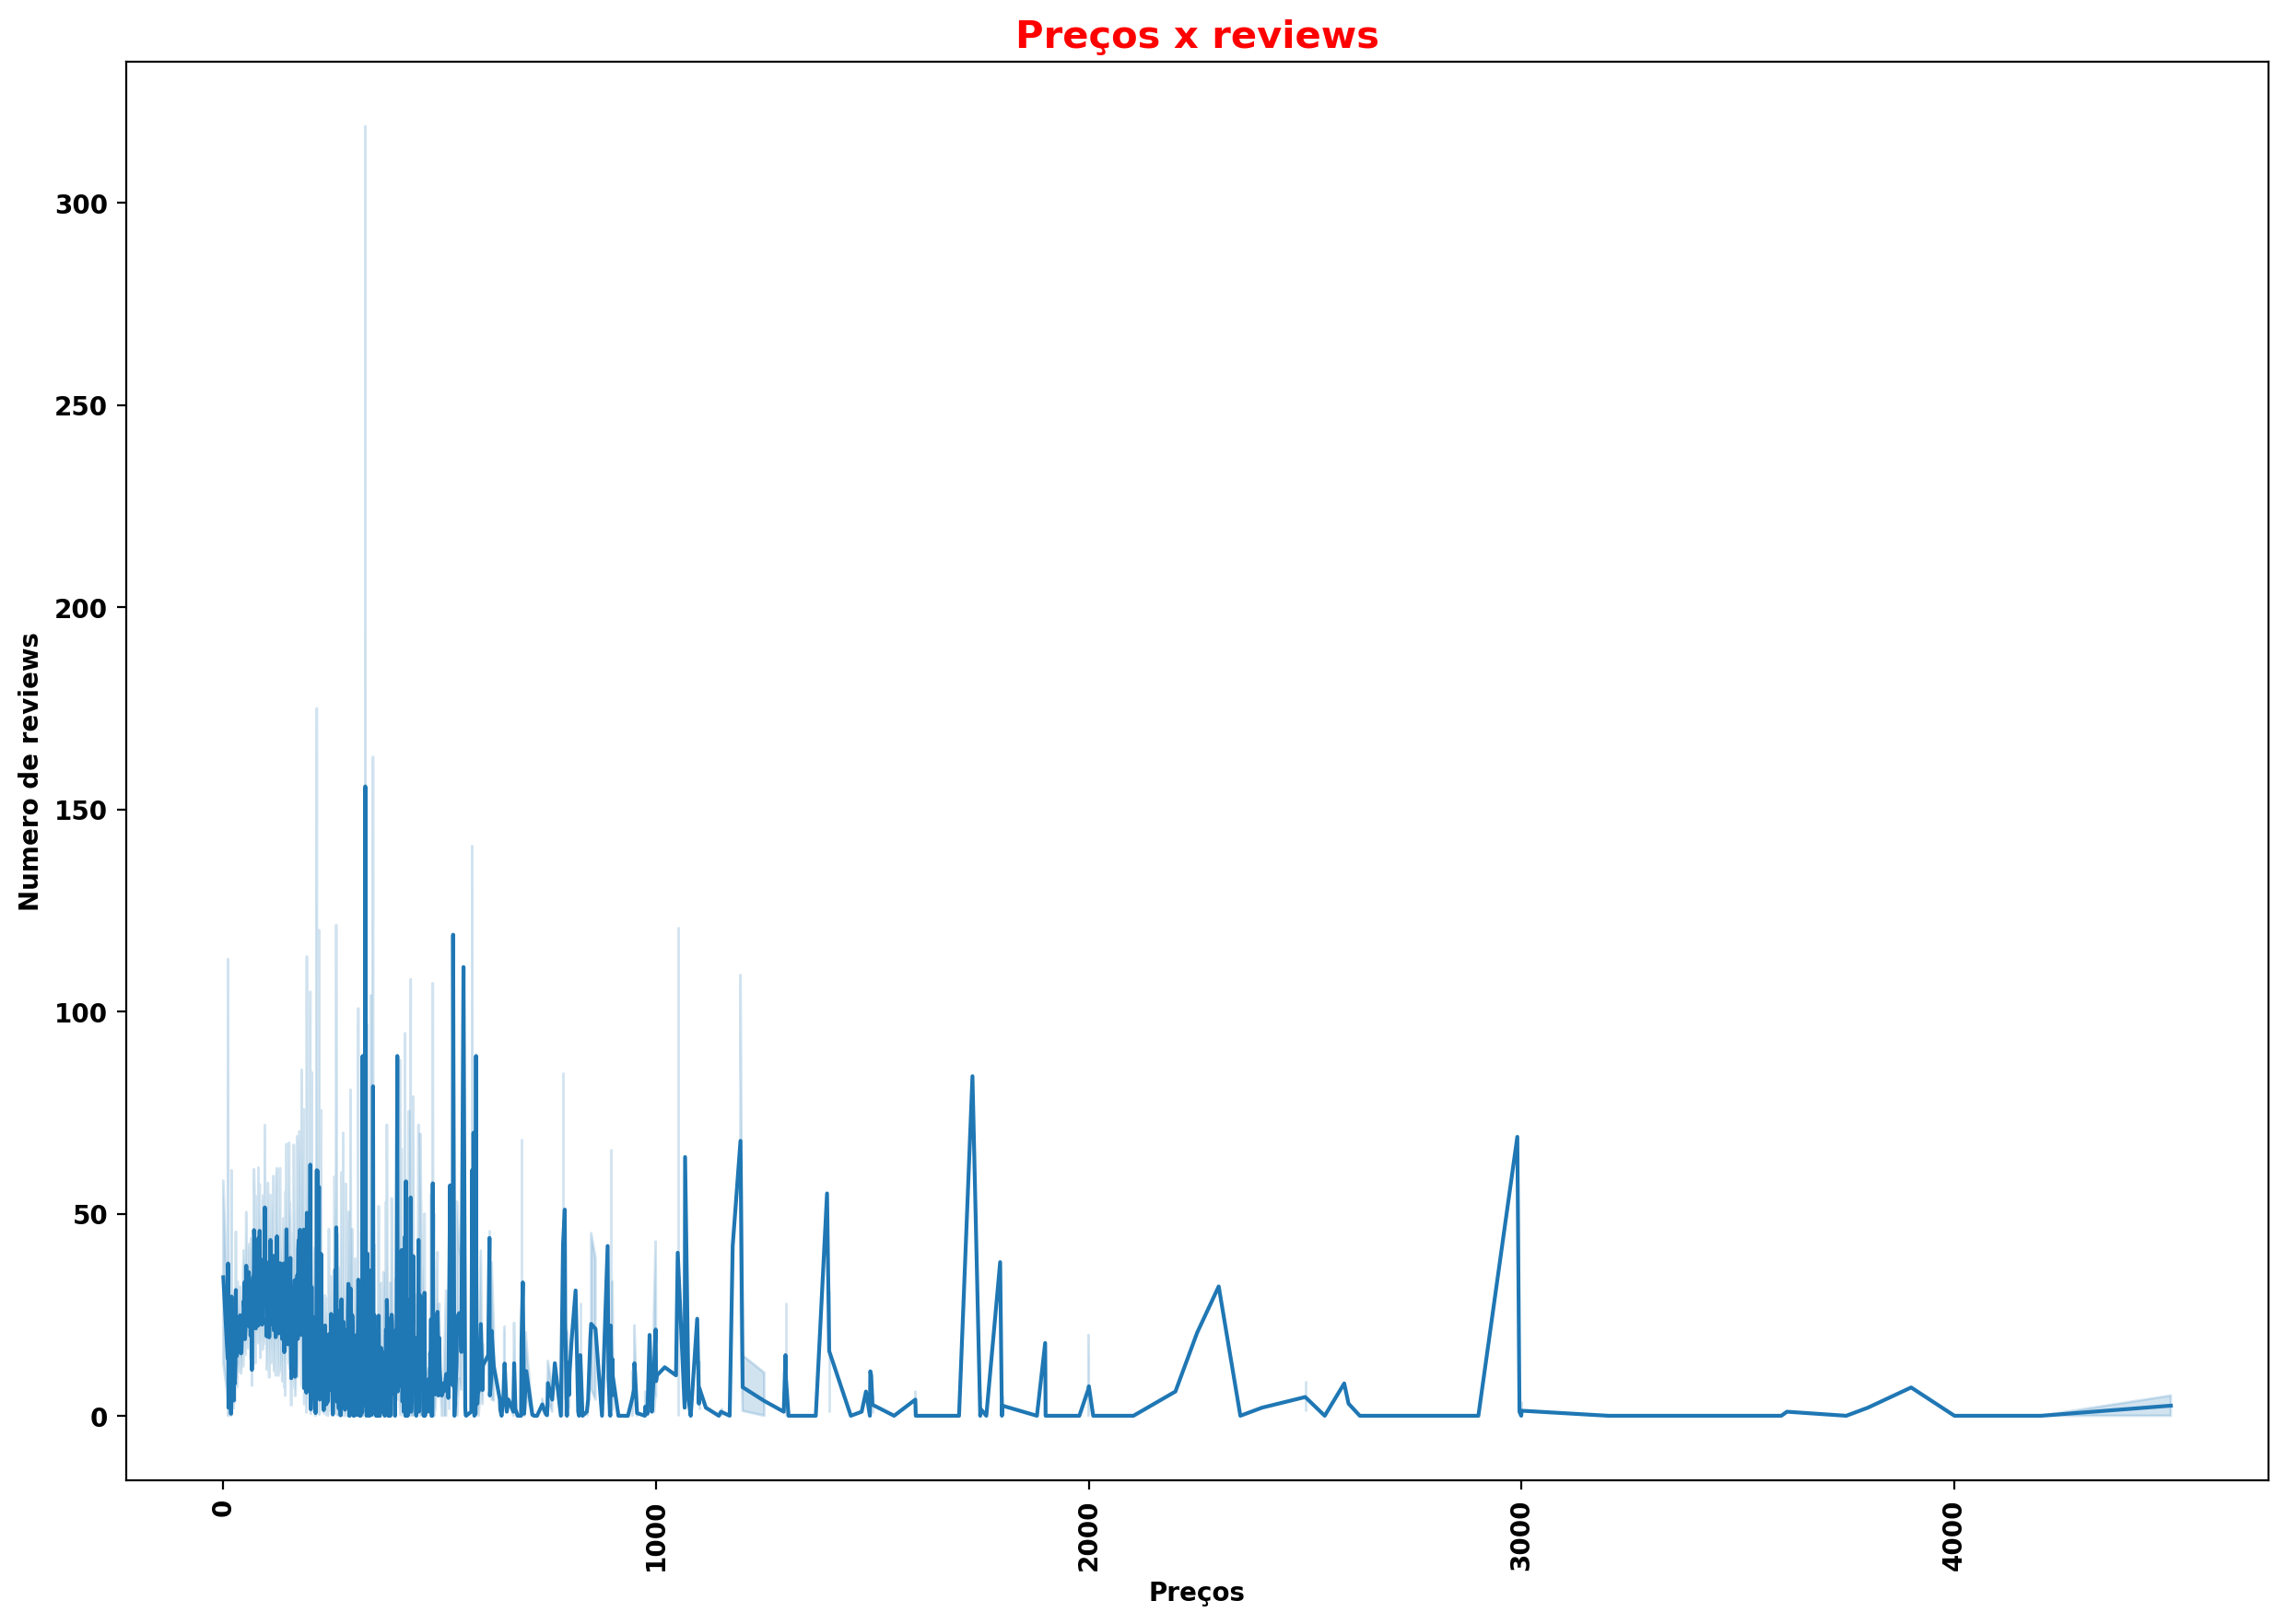

In [32]:
plt.figure(figsize=(15,10),dpi=200),
plt.style.use('default')
ax = sns.lineplot(x="price", y="numero_de_reviews", data=df[df['price']<5000])
plt.title("Preços x reviews", weight="bold", c="red", fontsize=15)
plt.xlabel("Preços",weight="bold",c="k")
plt.xticks(rotation=90, weight="bold")
plt.ylabel("Numero de reviews",weight= "bold",c="k")
plt.yticks(weight="bold")

plt.show()

Aparentemente não há relação

## **- Existe algum padrão no texto do nome do local para lugares de mais alto valor?

In [93]:
df.groupby('nome').mean().sort_values('price',ascending = False)['price'][:20]

C:\Users\arsnf\AppData\Local\Temp\ipykernel_19224\3742982432.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('nome').mean().sort_values('price',ascending = False)['price'][:20]


nome
Luxury 1 bedroom apt. -stunning Manhattan views       10000.0
Furnished room in Astoria apartment                   10000.0
1-BR Lincoln Center                                   10000.0
Quiet, Clean, Lit @ LES & Chinatown                    9999.0
Spanish Harlem Apt                                     9999.0
2br - The Heart of NYC: Manhattans Lower East Side     9999.0
Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho      8500.0
Film Location                                          8000.0
East 72nd Townhouse by (Hidden by Airbnb)              7703.0
70' Luxury MotorYacht on the Hudson                    7500.0
Gem of east Flatbush                                   7500.0
3000 sq ft daylight photo studio                       6800.0
Apartment New York \nHell’s Kitchens                   6500.0
SUPER BOWL Brooklyn Duplex Apt!!                       6500.0
Luxury TriBeCa Apartment at an amazing price           6500.0
Park Avenue Mansion by (Hidden by Airbnb)              6419.0
UWS

Existem menções a palavras que remetem a luxo como 'luxury'. Também referências ao superbowl e filmes como chamariz

## Conclusões Iniciais


Nessa análise inicial vimos que existem *outliers* em algumas das variáveis. Não foram encontradas grandes correlações entre as variáveis, logo não se pode tirar grandes conclusões utilizando relações entre elas. Porém pode-se concluir a partir desta análise de dados que o distrito de *Manhattan* é sem sombra de dúvidas o mais caro e também ganha em número de imóveis disponíveis. 

Após essa etapa, podemos realizar a limpeza dos dados e criar um modelo de previsão de preços: não utilizaremos as colunas latitude e longitude, pois são redundantes (neste caso) com o bairro. As colunas de id não acrescentam em nada para o modelo, assim como as colunas de ultima_review e reviews_por_mes, como vimos terem muitos dados faltantes. 

Eliminaremos os dados que denotam erros, como preço = 0. Também trataremos os dados com disponibilidade_365 = 0 por não fazer sentido um imóvel que não está disponível para locação.

A coluna de nome poderia ter um indicativo do interesse e ser aplicado em uma predição por classificação. Porém, nosso intuito aqui é criar um modelo de predição de preços baseado nos dados do concorrente. Portanto, faremos modelos de regressão que já será suficiente para o nosso objetivo atual. Escolheremos entre uma regressão linear e uma por árvore de decisões que tenham o melhor R2 por serem de fácil implementação e ideiais para nosso protótipo.

## Limpando dados: missing e outliers

Para os dados faltantes, apenas subustituirems com um hifem pois não nos afetará. Enquanto os valores com outliers, eliminaremos os dados que não fazem sentido

In [33]:
df.isna().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

In [34]:
df.fillna("-", inplace = True)
df.isna().sum()

id                               0
nome                             0
host_id                          0
host_name                        0
bairro_group                     0
bairro                           0
latitude                         0
longitude                        0
room_type                        0
price                            0
minimo_noites                    0
numero_de_reviews                0
ultima_review                    0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64

In [35]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,48894.0,1.901753e+07,1.098288e+07,2595.00000,9.472371e+06,1.967743e+07,2.915225e+07,3.648724e+07
host_id,48894.0,6.762139e+07,7.861118e+07,2438.00000,7.822737e+06,3.079553e+07,1.074344e+08,2.743213e+08
latitude,48894.0,4.072895e+01,5.452939e-02,40.49979,4.069010e+01,4.072308e+01,4.076312e+01,4.091306e+01
longitude,48894.0,-7.395217e+01,4.615712e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48894.0,1.527208e+02,2.401566e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimo_noites,48894.0,7.030085e+00,2.051074e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
numero_de_reviews,48894.0,2.327476e+01,4.455099e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
calculado_host_listings_count,48894.0,7.144005e+00,3.295286e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
disponibilidade_365,48894.0,1.127762e+02,1.316187e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


In [44]:
df_limpo = df.drop(df.query('price == 0').index)
#df_limpo.drop(df_limpo.query('disponibilidade_365 == 0').index, inplace = True)
df_limpo.drop(['id', 'host_id', 'nome', 'host_name', 'latitude', 'longitude', 'ultima_review', 'reviews_por_mes'], axis = 1, inplace = True)
df_limpo.query('price == 0')

,bairro_group,bairro,room_type,price,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365


## Modelos

## Linear Regression Model

In [59]:
df_le = df_limpo.copy()
le = LabelEncoder()                                            
le.fit(df_le['bairro_group'])
df_le['bairro_group']=le.transform(df_le['bairro_group'])    

le.fit(df_le['bairro'])
df_le['bairro']=le.transform(df_le['bairro'])

le =LabelEncoder()
le.fit(df_le['room_type'])
df_le['room_type']=le.transform(df_le['room_type'])

df_le.head()

,bairro_group,bairro,room_type,price,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365
0,2,127,0,225,1,45,2,355
1,2,94,1,150,3,0,1,365
2,1,41,0,89,1,270,1,194
3,2,61,0,80,10,9,1,0
4,2,137,0,200,3,74,1,129


In [116]:
lm = LinearRegression()
X = df_le.drop('price', axis = 1)
y = np.log(df_le['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

lm.fit(X_train,y_train)
y_predicts = lm.predict(X_test)

print("""
        Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(metrics.mean_squared_error(y_test, y_predicts)),
        r2_score(y_test,y_predicts),
        mean_absolute_error(y_test,y_predicts)
        ))



        Mean Squared Error: 0.5514436919529591
        R2 Score: 0.3886498395579113
        Mean Absolute Error: 0.4012388135574933
     


## Árvore de decisão

In [163]:
clf = DecisionTreeRegressor(criterion="friedman_mse",max_depth=10,random_state=101,  min_samples_split=10,
    min_samples_leaf=10, ccp_alpha=0.00001 )
rt = clf.fit(X_train,y_train)

y_pred = rt.predict(X_test)

print("""
        Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        r2_score(y_test,y_pred),
        mean_absolute_error(y_test,y_pred)
        ))


        Mean Squared Error: 0.48851493351038894
        R2 Score: 0.5202186381469218
        Mean Absolute Error: 0.3456844583169076
     


In [207]:
pd.DataFrame(y_pred).to_csv('y_pred.csv')

## Sistema para recomendação

In [198]:
imovel = {'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'price': 225,
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}

imovel_list = [1, 127, 0, 1, 45, 2, 355]

In [157]:
df[:1]

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


In [203]:
np.exp(y_pred[0])

118.79400737814261

In [172]:
f = open('modelo.pkl', 'wb')
pickle.dump(rt, f)
f.close()

In [201]:
with open('modelo.pkl', 'rb') as f:
    modelo = pickle.load(f)
    
modelo.predict(imovel_list)

118.79400737814261